## Ames Housing Price Predictions
### Version 3
#### January 2023

---


<B>Key Objectives:</B>
- Create model to predict housing prices based on historical data
- Evaluate model
- Disseminate techniques and methods to technical audience and colleagues

---

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import time
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import NuSVR

from catboost import CatBoostRegressor
from verstack import NaNImputer

color_pal = sns.color_palette('deep')
%matplotlib inline

In [2]:
# Train and test data sets were already provided by competition.

train = pd.read_csv('./data/train.csv', index_col='Id')
test = pd.read_csv('./data/test.csv', index_col='Id')

train.sort_index(inplace=True)
test.sort_index(inplace=True)

train['isTrain']=True
test['isTrain']=False

mega=(pd.concat([train,test], axis=0))
mega.sort_index(inplace=True)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
mega.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,isTrain
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,215000.0,True
2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,NaN,False
3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,172000.0,True
4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,NaN,False
5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,189900.0,True


In [4]:
train.shape, test.shape, mega.shape 

((2051, 81), (878, 80), (2929, 81))

### Evaluate provided Train dataset

In [5]:
train.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,isTrain
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,215000,True
3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,172000,True
5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,189900,True
8,527145080,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,191500,True
9,527146030,120,RL,39.0,5389,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1995,1996,Gable,CompShg,CemntBd,CmentBd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,1180.0,Unf,0.0,415.0,1595.0,GasA,Ex,Y,SBrkr,1616,0,0,1616,1.0,0.0,2,0,2,1,Gd,5,Typ,1,TA,Attchd,1995.0,RFn,2.0,608.0,TA,TA,Y,237,152,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,236500,True


In [6]:
train.shape

(2051, 81)

In [7]:
train.describe()

,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2.051000e+03,2051.000000,1721.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2029.000000,2050.000000,2050.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2049.000000,2049.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,1937.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,7.135900e+08,57.008776,69.055200,10065.208191,6.112140,5.562165,1971.708922,1984.190151,99.695909,442.300488,47.959024,567.728293,1057.987805,1164.488055,329.329108,5.512921,1499.330083,0.427526,0.063446,1.577279,0.371039,2.843491,1.042906,6.435885,0.590931,1978.707796,1.776585,473.671707,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,6.219893,2007.775719,181469.701609
std,1.886918e+08,42.824223,23.260653,6742.488909,1.426271,1.104497,30.177889,21.036250,174.963129,461.204124,165.000901,444.954786,449.410704,396.446923,425.671046,51.068870,500.447829,0.522673,0.251705,0.549279,0.501043,0.826618,0.209790,1.560225,0.638516,25.441094,0.764537,215.934561,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,2.744736,1.312014,79258.659352
min,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,5.284581e+08,20.000000,58.000000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,0.000000,0.000000,220.000000,793.000000,879.500000,0.000000,0.000000,1129.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,5.354532e+08,50.000000,68.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,368.000000,0.000000,474.500000,994.500000,1093.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,9.071801e+08,70.000000,80.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,161.000000,733.750000,0.000000,811.000000,1318.750000,1405.000000,692.500000,0.000000,1728.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,9.241520e+08,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,5095.000000,1862.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1418.000000,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 1 to 2930
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PID              2051 non-null   int64  
 1   MS SubClass      2051 non-null   int64  
 2   MS Zoning        2051 non-null   object 
 3   Lot Frontage     1721 non-null   float64
 4   Lot Area         2051 non-null   int64  
 5   Street           2051 non-null   object 
 6   Alley            140 non-null    object 
 7   Lot Shape        2051 non-null   object 
 8   Land Contour     2051 non-null   object 
 9   Utilities        2051 non-null   object 
 10  Lot Config       2051 non-null   object 
 11  Land Slope       2051 non-null   object 
 12  Neighborhood     2051 non-null   object 
 13  Condition 1      2051 non-null   object 
 14  Condition 2      2051 non-null   object 
 15  Bldg Type        2051 non-null   object 
 16  House Style      2051 non-null   object 
 17  Overall Qual  

In [9]:
# Add age column
train['age'] = (train['Yr Sold'] - train['Year Built']).abs()
mega['age'] = (mega['Yr Sold'] - mega['Year Built']).abs()
test['age'] = (test['Yr Sold'] - test['Year Built']).abs()

In [10]:
# Check data types
train.dtypes

PID                  int64
MS SubClass          int64
MS Zoning           object
Lot Frontage       float64
Lot Area             int64
Street              object
Alley               object
Lot Shape           object
Land Contour        object
Utilities           object
Lot Config          object
Land Slope          object
Neighborhood        object
Condition 1         object
Condition 2         object
Bldg Type           object
House Style         object
Overall Qual         int64
Overall Cond         int64
Year Built           int64
Year Remod/Add       int64
Roof Style          object
Roof Matl           object
Exterior 1st        object
Exterior 2nd        object
Mas Vnr Type        object
Mas Vnr Area       float64
Exter Qual          object
Exter Cond          object
Foundation          object
Bsmt Qual           object
Bsmt Cond           object
Bsmt Exposure       object
BsmtFin Type 1      object
BsmtFin SF 1       float64
BsmtFin Type 2      object
BsmtFin SF 2       float64
B

In [11]:
train.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,isTrain,age
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,215000,True,50
3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,172000,True,52
5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,189900,True,13
8,527145080,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,191500,True,18
9,527146030,120,RL,39.0,5389,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1995,1996,Gable,CompShg,CemntBd,CmentBd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,1180.0,Unf,0.0,415.0,1595.0,GasA,Ex,Y,SBrkr,1616,0,0,1616,1.0,0.0,2,0,2,1,Gd,5,Typ,1,TA,Attchd,1995.0,RFn,2.0,608.0,TA,TA,Y,237,152,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,236500,True,15


In [12]:
# Data types look ok

### Start EDA

In [13]:
# Identify Numerical and String columns

nm1 = train.select_dtypes(include = [np.number])
sd1 = train.select_dtypes(exclude = [np.number])

# Initial Correlation
n1 = nm1.corr()

<AxesSubplot: >

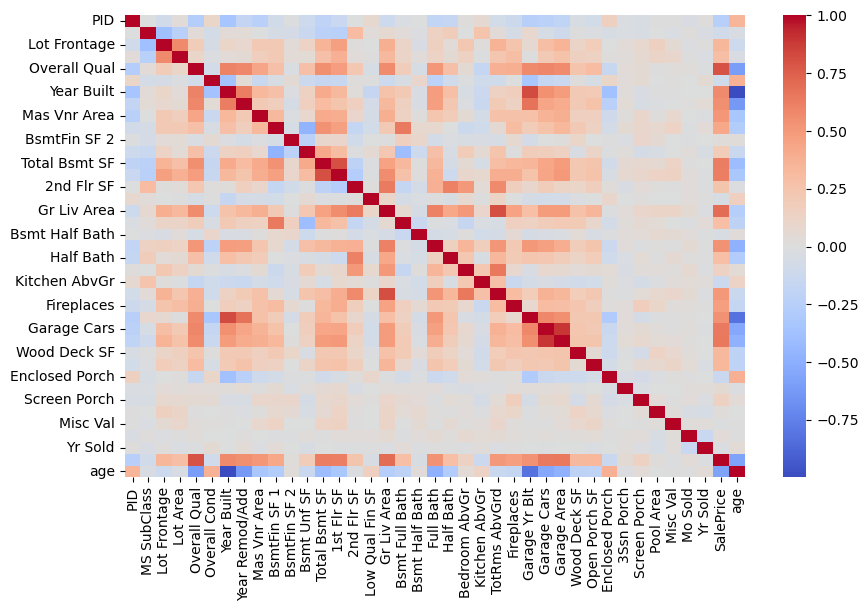

In [14]:
# Corr heatmap
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
sns.heatmap(n1, cmap='coolwarm')

### What factors are correlated with SalePrice

In [15]:
# Corr table for SalesPrice
sp_corr = pd.DataFrame(n1['SalePrice'].sort_values(ascending=False))
sp_corr

,SalePrice
SalePrice,1.000000
Overall Qual,0.800207
Gr Liv Area,0.697038
Garage Area,0.650270
Garage Cars,0.648220
Total Bsmt SF,0.628925
1st Flr SF,0.618486
Year Built,0.571849
Year Remod/Add,0.550370
Full Bath,0.537969


<AxesSubplot: >

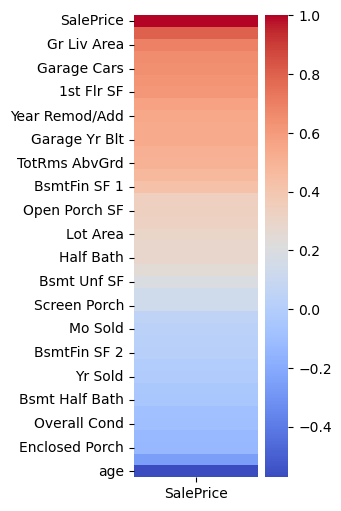

In [16]:
# SalePrice Corr heatmap
fig, ax = plt.subplots()
fig.set_size_inches(2, 6)
sns.heatmap(sp_corr, cmap='coolwarm')

In [17]:
sp_corr.index

Index(['SalePrice', 'Overall Qual', 'Gr Liv Area', 'Garage Area',
       'Garage Cars', 'Total Bsmt SF', '1st Flr SF', 'Year Built',
       'Year Remod/Add', 'Full Bath', 'Garage Yr Blt', 'Mas Vnr Area',
       'TotRms AbvGrd', 'Fireplaces', 'BsmtFin SF 1', 'Lot Frontage',
       'Open Porch SF', 'Wood Deck SF', 'Lot Area', 'Bsmt Full Bath',
       'Half Bath', '2nd Flr SF', 'Bsmt Unf SF', 'Bedroom AbvGr',
       'Screen Porch', '3Ssn Porch', 'Mo Sold', 'Pool Area', 'BsmtFin SF 2',
       'Misc Val', 'Yr Sold', 'Low Qual Fin SF', 'Bsmt Half Bath',
       'MS SubClass', 'Overall Cond', 'Kitchen AbvGr', 'Enclosed Porch', 'PID',
       'age'],
      dtype='object')

In [18]:
# Most Correlated columns at this point include the below:
initial_corr_col = ['Overall Qual', 'Gr Liv Area', 'Garage Area',
       'Garage Cars', 'Total Bsmt SF', '1st Flr SF', 'Year Built',
       'Year Remod/Add', 'Full Bath', 'Garage Yr Blt', 'Mas Vnr Area',
       'TotRms AbvGrd', 'Fireplaces', 'BsmtFin SF 1']

initial_corr_col

['Overall Qual',
 'Gr Liv Area',
 'Garage Area',
 'Garage Cars',
 'Total Bsmt SF',
 '1st Flr SF',
 'Year Built',
 'Year Remod/Add',
 'Full Bath',
 'Garage Yr Blt',
 'Mas Vnr Area',
 'TotRms AbvGrd',
 'Fireplaces',
 'BsmtFin SF 1']

---
### Does it matter when we sell our home?

<AxesSubplot: xlabel='Yr Sold,Mo Sold'>

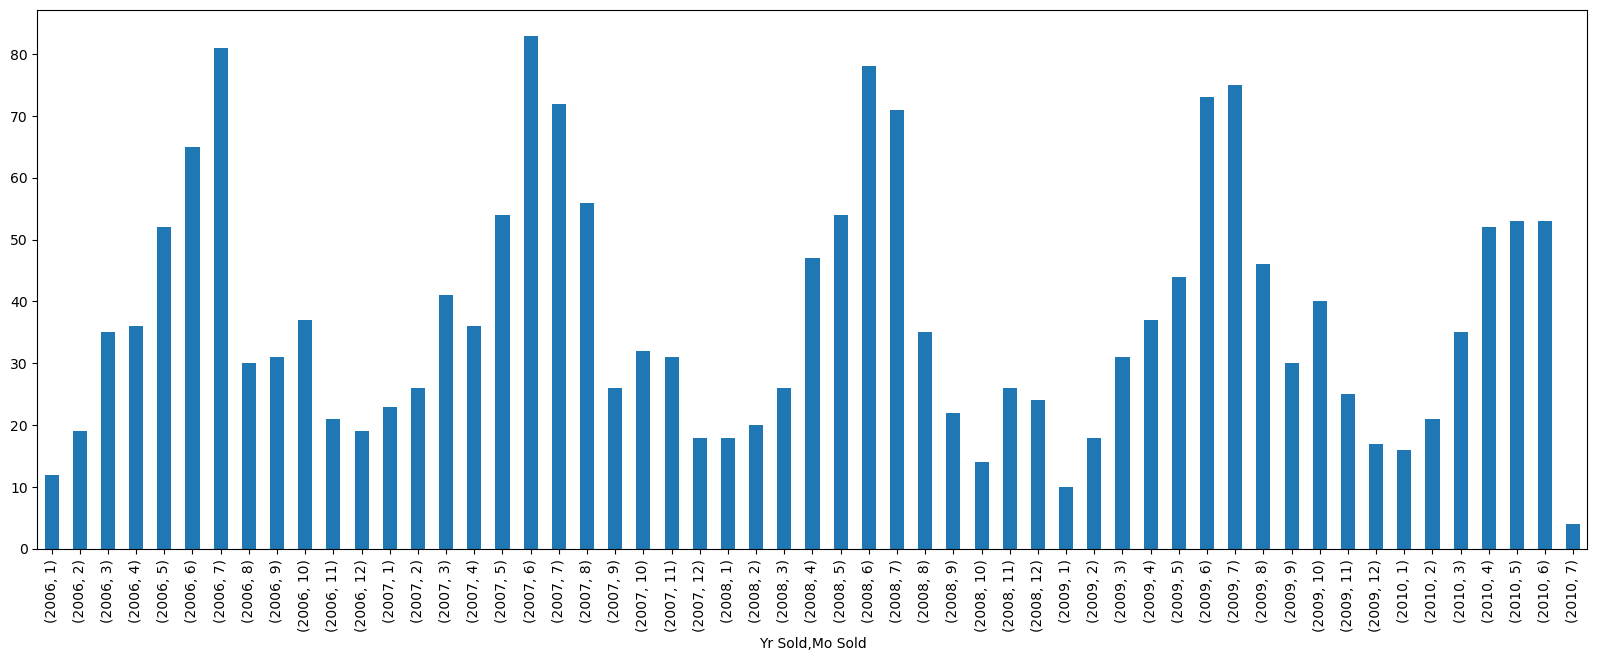

In [19]:
g = train.groupby(['Yr Sold', 'Mo Sold']).SalePrice.count()

g.plot(kind='bar', figsize=(20,7))

#### June and July have higher sales volumes, therefore likely to have more competition but perhaps also more buyers
---

### Will location impact SalePrice? Any trends?  What are the desirable neighborhoods?

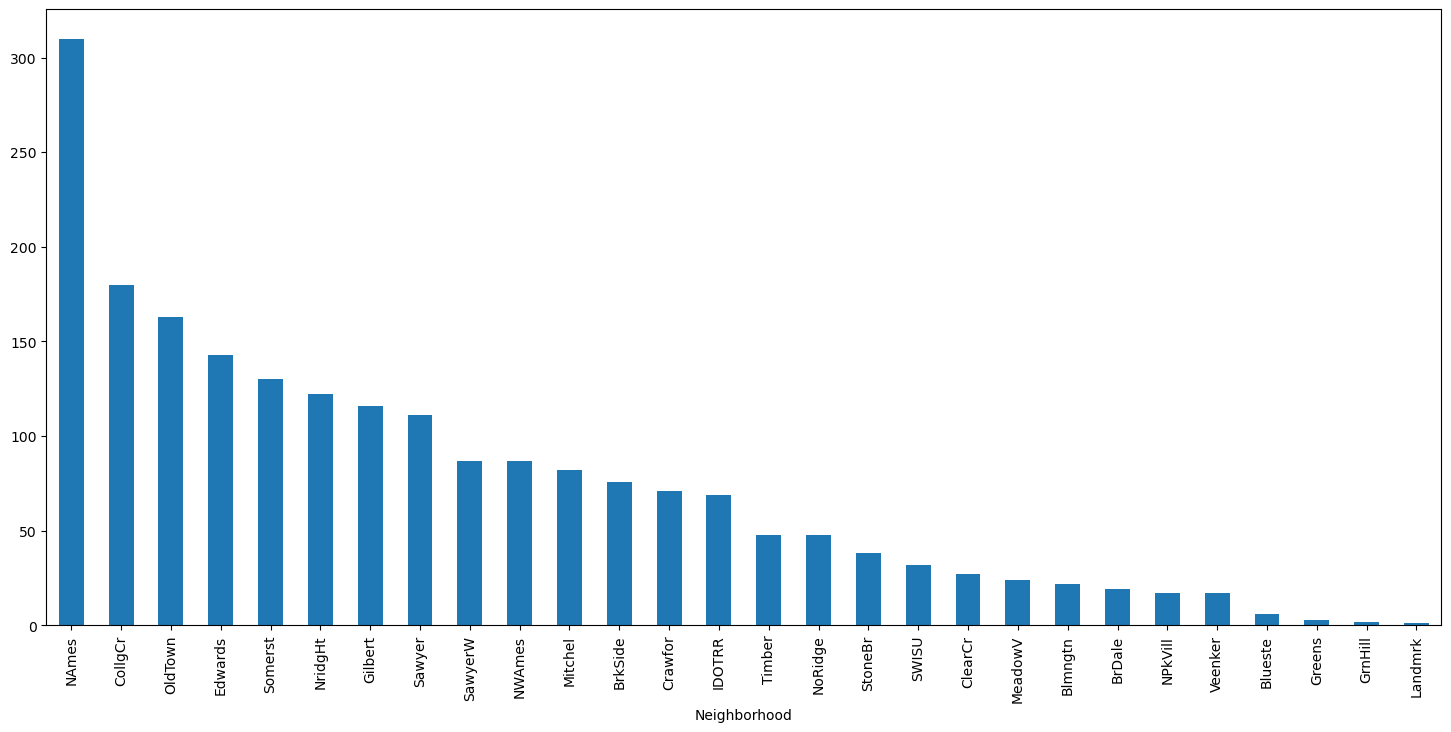

In [20]:
l1 = train.groupby('Neighborhood').SalePrice.count().sort_values(ascending=False)

l1.plot(kind='bar', figsize= (18,8))
plt.title = ('Sales Counts by Neighborhood')

#### Yes, there is a clear trend.  Neighborhood will greatly influence SalePrice


### Evaluate distribution of target SalePrice in train dataset

<AxesSubplot: xlabel='SalePrice', ylabel='Count'>

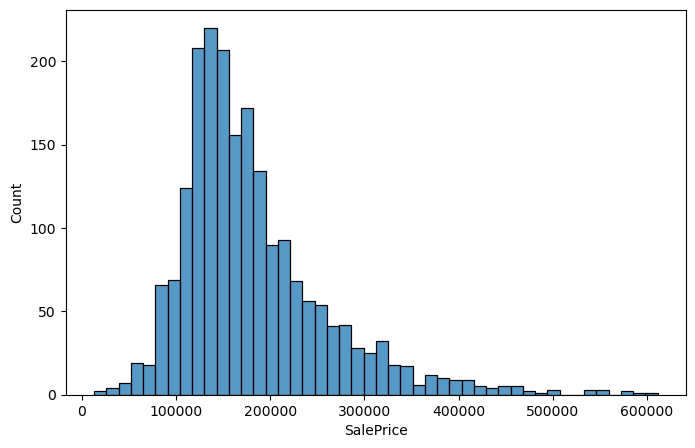

In [21]:
# Evaluate distribution of SalePrice in train dataset
plt.figure(figsize = (8,5))
sns.histplot(train['SalePrice'])

#### Right-skewed, meaning higher concentration of lower-priced houses
#### Model will benefit from log normalization

---

### Outliers check

<AxesSubplot: xlabel='Gr Liv Area', ylabel='SalePrice'>

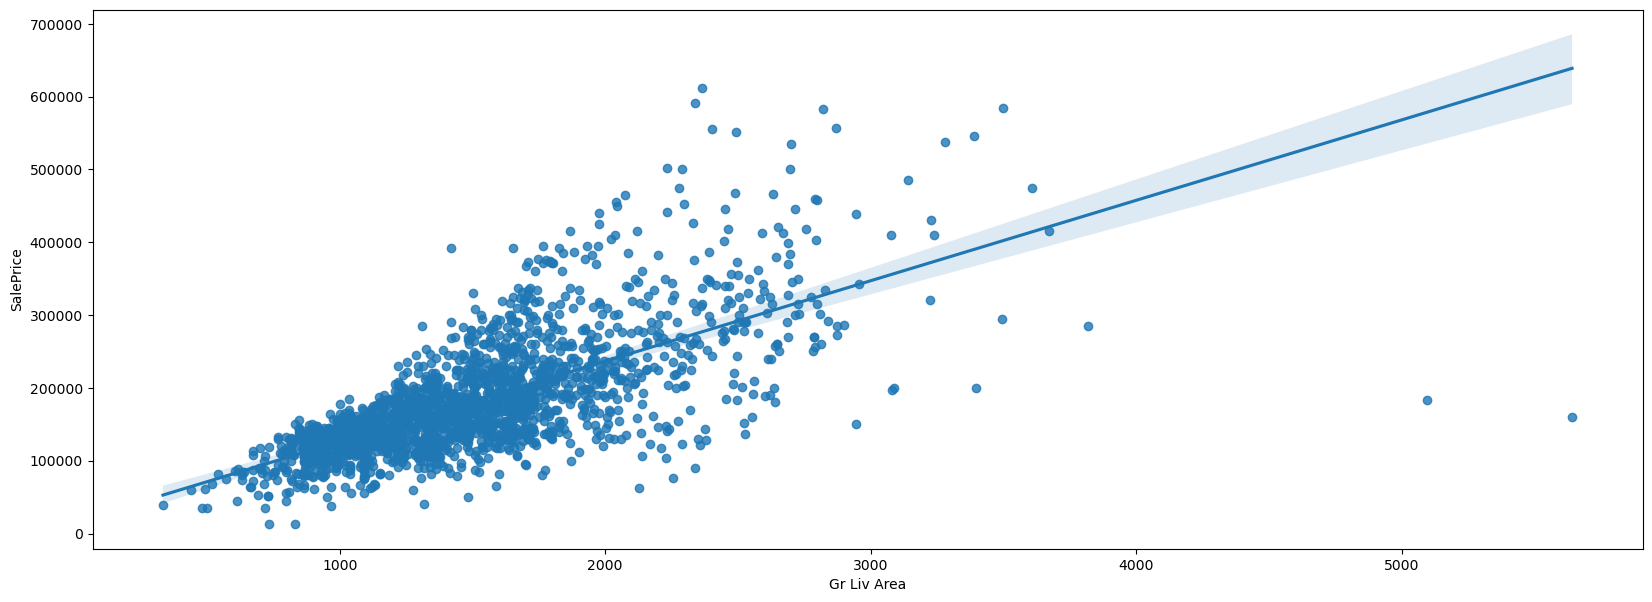

In [22]:
# check for outliers
# let's explore Gr Living Area vs saleprice since it had
# a high correlation and is the first highest variable that's numeric

plt.figure(figsize = (20,7))
sns.regplot(x=train['Gr Liv Area'],
            y=train.SalePrice)

In [23]:
# There's some outliers here.  Houses with 5K sq ft but low price !
# Most houses within 4K sq ft, so we can omit everything beyond it
# This will make the dataset better approximate a normal distribution

train.drop(train[train['Gr Liv Area'] >= 3700].index, inplace=True)

<AxesSubplot: xlabel='Gr Liv Area', ylabel='SalePrice'>

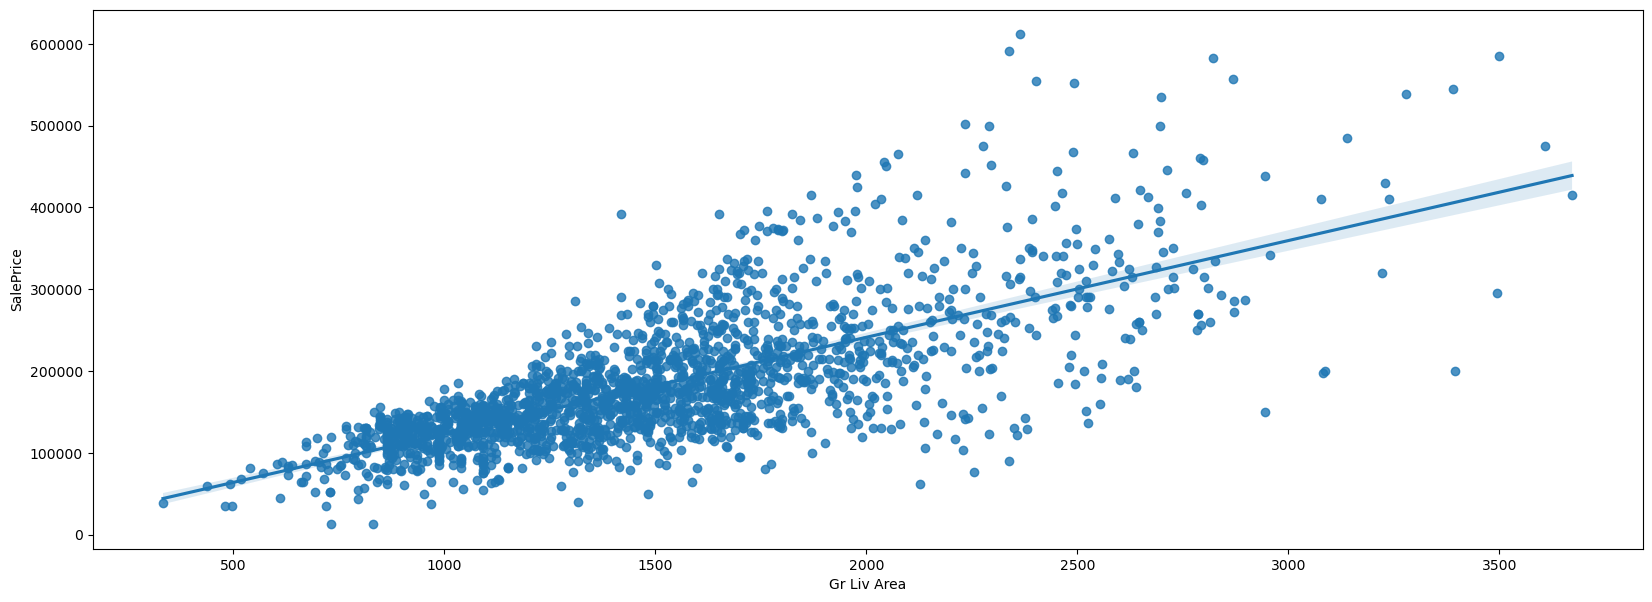

In [24]:
# Plot again to view change
plt.figure(figsize = (20,7))
sns.regplot(x = train['Gr Liv Area'],
            y = train.SalePrice)

In [25]:
# Looks better at the high end of Gr Liv Area,
# However there appear to be some potential outliers at the low end

In [26]:
# Contribute to SalePrice normal distribution by dropping low SalePrice outliers
train.drop(train[train['SalePrice'] < 51_000].index, inplace=True)

<AxesSubplot: xlabel='age', ylabel='SalePrice'>

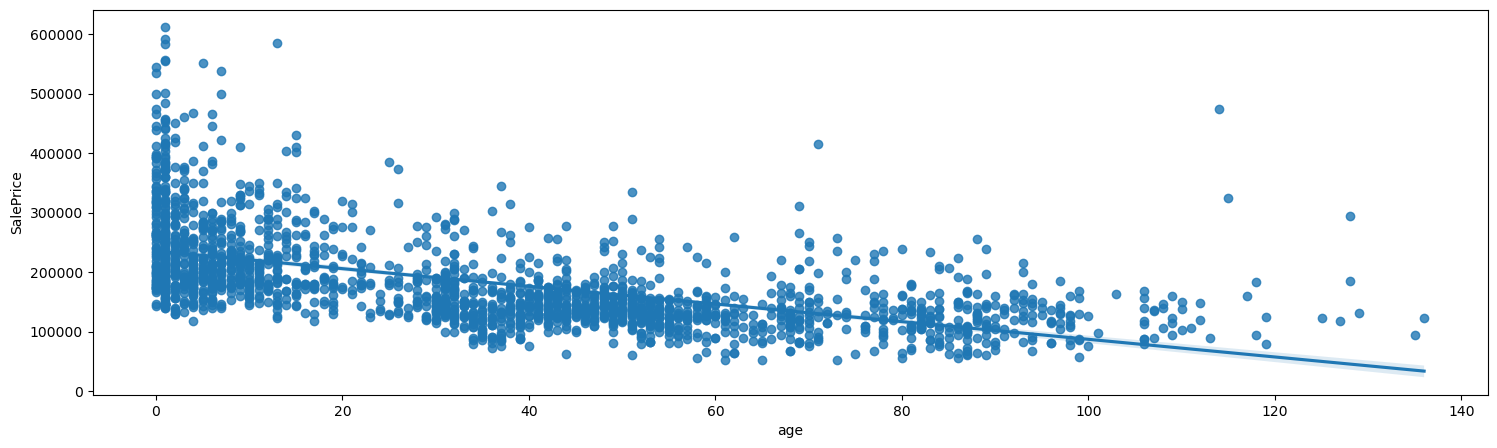

In [27]:
# Does [Age x SalePrice] contain any substantial outliers that could be throwing model off?
plt.figure(figsize = (18,5))
sns.regplot(x = train['age'],
            y = train.SalePrice)

In [28]:
# A few notable outliers stand out
# - Younger than 10 years and sold for more than 550K
# - Older than 60 years and sold for more than 420K
# - Older than 100 years and sold for more than 300K

# I sliced the data a few different ways (I included an example below) however when I removed these apparent outliers model scores suffered,
# therefore I have elected to keep them in.  Since the training data is only 30% of total, its possible the suspected outliers are not outliers at all...

In [29]:
train[(train['SalePrice']>=600_000) & (train['age']<=10)].sort_values('SalePrice')

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,isTrain,age
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
45,528150070,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,9,5,2009,2010,Hip,CompShg,VinylSd,VinylSd,Stone,760.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2188.0,Unf,0.0,142.0,2330.0,GasA,Ex,Y,SBrkr,2364,0,0,2364,1.0,0.0,2,1,2,1,Ex,11,Typ,2,Gd,Attchd,2009.0,Fin,3.0,820.0,TA,TA,Y,0,67,0,0,0,0,NaN,NaN,NaN,0,3,2010,New,611657,True,1


---
### Evaluate missing data

In [30]:
# Check for missing values and NaNs
na_count = pd.DataFrame(mega.isna().sum().sort_values(ascending=False), columns=['Count'])
na_count['%'] = (na_count['Count'] / mega.shape[0])*(100)
na_count

,Count,%
Pool QC,2916,99.556163
Misc Feature,2823,96.381017
Alley,2731,93.240014
Fence,2357,80.471151
Fireplace Qu,1422,48.548993
SalePrice,878,29.976101
Lot Frontage,490,16.729259
Garage Cond,159,5.428474
Garage Yr Blt,159,5.428474
Garage Finish,159,5.428474


In [31]:
# Plenty of missing values observed,
# Top four columns have too much missing data (80 to 99.6%) to apply imputation (PoolQC, Misc Feature, Alley, Fence)
# Those columns will be dropped since the missing data rate is too high.
# Model will benefit from imputing other columns that have missing data

In [32]:
# Create list of columns with high missing data pct to drop
delly = list(na_count.index.values.tolist())[0:4]

In [33]:
delly

['Pool QC', 'Misc Feature', 'Alley', 'Fence']

In [34]:
# Drop columns with high missing data percentage
train.drop(columns=delly, axis=1, inplace=True)

# Check indeed dropped
train.isna().sum().sort_values(ascending=False)

Fireplace Qu       989
Lot Frontage       330
Garage Yr Blt      110
Garage Finish      110
Garage Qual        110
Garage Cond        110
Garage Type        109
Bsmt Exposure       54
BsmtFin Type 2      52
Bsmt Cond           51
Bsmt Qual           51
BsmtFin Type 1      51
Mas Vnr Area        22
Mas Vnr Type        22
BsmtFin SF 1         1
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Bsmt Half Bath       1
Bsmt Full Bath       1
Garage Cars          1
Garage Area          1
Misc Val             0
isTrain              0
Full Bath            0
Half Bath            0
Bedroom AbvGr        0
Kitchen AbvGr        0
Kitchen Qual         0
SalePrice            0
Sale Type            0
Yr Sold              0
Mo Sold              0
Pool Area            0
Screen Porch         0
3Ssn Porch           0
Enclosed Porch       0
TotRms AbvGrd        0
Functional           0
Fireplaces           0
Open Porch SF        0
Wood Deck SF         0
Paved Drive          0
Gr Liv Area

In [35]:
train.shape

(2036, 78)

In [36]:
mega.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,isTrain,age
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,215000.0,True,50
2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,NaN,False,49
3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,172000.0,True,52
4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,NaN,False,42
5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,189900.0,True,13


In [37]:
mega.drop(columns=delly, axis=1, inplace=True)
test.drop(columns=delly, axis=1, inplace=True)

---
### Impute missing values using MICE

In [38]:
imp_mega1 = NaNImputer(train_sample_size=999_999,
                       verbose=True)

mega2 = imp_mega1.impute(train=True,
                         data=mega).copy()


 * Initiating NaNImputer.impute
     . Dataset dimensions:
     .. rows:         2929
     .. columns:      78
     .. mb in memory: 1.75
     .. NaN cols num: 24

   - Drop hopeless NaN cols

   - Processing whole data for imputation
     . Processed 10 cols; 40 to go
     . Processed 20 cols; 30 to go
     . Processed 30 cols; 20 to go
     . Processed 40 cols; 10 to go

   - Imputing single core 24 cols
     . Imputed (regression) - 490      NaN in Lot Frontage
     . Imputed (multiclass) - 23       NaN in Mas Vnr Type
     . Imputed (regression) - 23       NaN in Mas Vnr Area
     . Imputed (multiclass) - 80       NaN in Bsmt Qual
     . Imputed (multiclass) - 80       NaN in Bsmt Cond
     . Imputed (multiclass) - 83       NaN in Bsmt Exposure
     . Imputed (multiclass) - 80       NaN in BsmtFin Type 1
     . Imputed (regression) - 1        NaN in BsmtFin SF 1
     . Imputed (multiclass) - 81       NaN in BsmtFin Type 2
     . Imputed (regression) - 1        NaN in BsmtFin SF 2


In [39]:
train2 = imp_mega1.impute(train=False, data=train).copy()


 * Initiating NaNImputer.impute
     . Dataset dimensions:
     .. rows:         2036
     .. columns:      78
     .. mb in memory: 1.21
     .. NaN cols num: 22

   - Drop hopeless NaN cols

   - Processing whole data for imputation
     . Processed 10 cols; 39 to go
     . Processed 20 cols; 29 to go
     . Processed 30 cols; 19 to go
     . Processed 40 cols; 9 to go

   - Imputing single core 22 cols
     . Imputed (regression) - 330      NaN in Lot Frontage
     . Imputed (multiclass) - 22       NaN in Mas Vnr Type
     . Imputed (regression) - 22       NaN in Mas Vnr Area
     . Imputed (multiclass) - 51       NaN in Bsmt Qual
     . Imputed (multiclass) - 51       NaN in Bsmt Cond
     . Imputed (multiclass) - 54       NaN in Bsmt Exposure
     . Imputed (multiclass) - 51       NaN in BsmtFin Type 1
     . Imputed (regression) - 1        NaN in BsmtFin SF 1
     . Imputed (multiclass) - 52       NaN in BsmtFin Type 2
     . Imputed (regression) - 1        NaN in BsmtFin SF 2
 

In [40]:
train2.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,isTrain,age
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,526301100,20,RL,141.0,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,0,5,2010,WD,215000,True,50
3,526351010,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,TA,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,12500,6,2010,WD,172000,True,52
5,527105010,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,0,3,2010,WD,189900,True,13
8,527145080,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,TA,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,0,1,2010,WD,191500,True,18
9,527146030,120,RL,39.0,5389,Pave,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1995,1996,Gable,CompShg,CemntBd,CmentBd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,1180.0,Unf,0.0,415.0,1595.0,GasA,Ex,Y,SBrkr,1616,0,0,1616,1.0,0.0,2,0,2,1,Gd,5,Typ,1,TA,Attchd,1995.0,RFn,2.0,608.0,TA,TA,Y,237,152,0,0,0,0,0,3,2010,WD,236500,True,15


In [41]:
test2 = imp_mega1.impute(train=False, data=test).copy()


 * Initiating NaNImputer.impute
     . Dataset dimensions:
     .. rows:         878
     .. columns:      77
     .. mb in memory: 0.52
     .. NaN cols num: 15

   - Drop hopeless NaN cols

   - Processing whole data for imputation
     . Processed 10 cols; 31 to go
     . Processed 20 cols; 21 to go
     . Processed 30 cols; 11 to go

   - Imputing single core 15 cols
     . Imputed (regression) - 160      NaN in Lot Frontage
     . Imputed (multiclass) - 1        NaN in Mas Vnr Type
     . Imputed (regression) - 1        NaN in Mas Vnr Area
     . Imputed (multiclass) - 25       NaN in Bsmt Qual
     . Imputed (multiclass) - 25       NaN in Bsmt Cond
     . Imputed (multiclass) - 25       NaN in Bsmt Exposure
     . Imputed (multiclass) - 25       NaN in BsmtFin Type 1
     . Imputed (multiclass) - 25       NaN in BsmtFin Type 2
     . Imputed (multiclass) - 1        NaN in Electrical
     . Imputed (multiclass) - 422      NaN in Fireplace Qu
     . Imputed (multiclass) - 44      

### Next I want to evaluate which variables have high variance when plotted against SalePrice and therefore are likely influencing SalePrice

In [42]:
sd1 = train2.select_dtypes(exclude = [np.number])

In [43]:
f1 = pd.melt(train2, id_vars = ['SalePrice'], value_vars = sorted(sd1))

<Figure size 2000x700 with 0 Axes>

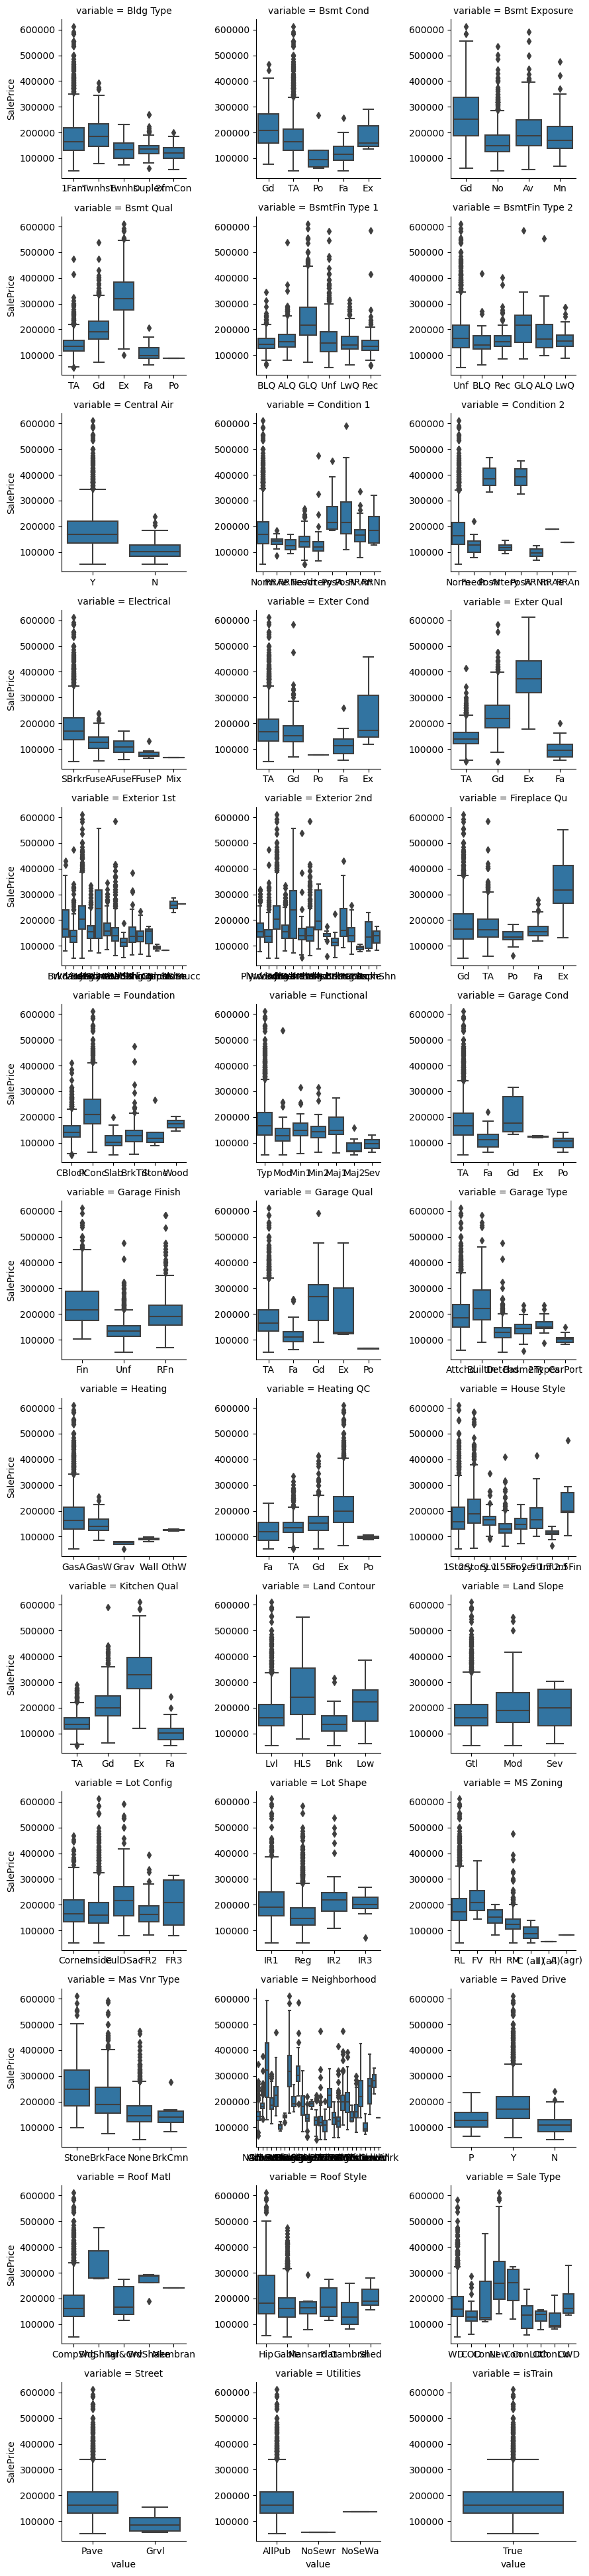

In [44]:
plt.figure(figsize = (20,7))
g1 = sns.FacetGrid(f1, col='variable', col_wrap=3, sharex=False, sharey = False)
g1 = g1.map(sns.boxplot, 'value', 'SalePrice')
g1.fig.tight_layout()

In [45]:
# Variables that visually stand out as having high variance and therefore likely greatly influence SalePrice include:

list2 = ['Neighborhood',
         'Condition 1',
         'Condition 2',
         'Exter Qual',
         'Fireplaces',
         'Full Bath',
         'Garage Cars',
         'MS SubClass',
         'Overall Cond',
         'Overall Qual',
         'TotRms AbvGrd',
         'Year Built',
         'Year Remod/Add'         
]

### Evaluate Variance using ANOVA

In [46]:
cat_features = sd1.columns

In [47]:
cat_features = ['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Sale Type']

In [48]:
# ANOVA - objective is to obtain p-values to determine which variables are statistically significant

anova = {'feature':[], 'f':[], 'p':[]}

for cat in cat_features:
    group_prices = []
    for group in train2[cat].unique():
        group_prices.append(train2[train2[cat] == group]['SalePrice'].values)
        
    f, p = scipy.stats.f_oneway(*group_prices)
    anova['feature'].append(cat)
    anova['f'].append(f)
    anova['p'].append(p)
    
anova = pd.DataFrame(anova)
anova = anova[['feature', 'f', 'p']]
anova.sort_values('p', inplace=True)

In [49]:
cat_s_sig = anova.sort_values('p')
cat_s_sig

# if p-value is less than 0.05 then it is SIGNIFICANT

,feature,f,p
7,Neighborhood,101.819644,0.000000e+00
17,Exter Qual,766.831219,0.000000e+00
29,Kitchen Qual,700.656864,1.073050e-312
20,Bsmt Qual,526.498983,8.912634e-312
33,Garage Finish,452.308301,3.196039e-163
19,Foundation,162.325094,2.043102e-145
32,Garage Type,119.718144,3.271983e-111
23,BsmtFin Type 1,114.846927,3.957393e-107
26,Heating QC,136.763276,1.405959e-103
16,Mas Vnr Type,171.506322,4.149993e-99


In [50]:
# Create list of top significant categorical features
cat_sig_list = cat_s_sig['feature'].head(20).values
cat_sig_list

array(['Neighborhood', 'Exter Qual', 'Kitchen Qual', 'Bsmt Qual',
       'Garage Finish', 'Foundation', 'Garage Type', 'BsmtFin Type 1',
       'Heating QC', 'Mas Vnr Type', 'Bsmt Exposure', 'Exterior 1st',
       'Exterior 2nd', 'Sale Type', 'MS Zoning', 'Lot Shape',
       'Paved Drive', 'Central Air', 'House Style', 'Roof Style'],
      dtype=object)

In [51]:
# Neighborhood, Exter Qual, Kitchen Qual, Bsmt Qual,
# Garage Finish, Foundation, Garage Type, Bsmt Fin Type 1,
# Heating QC are leading statistically significant features

---
## Feature Engineering

### Neighborhood Feature Engineering

In [52]:
neigh_mean_price = train2.groupby(by='Neighborhood')['SalePrice'].mean()

In [53]:
neigh_mean_price.sort_values(ascending=False)

Neighborhood
StoneBr    329675.736842
NridgHt    322831.352459
NoRidge    316294.125000
GrnHill    280000.000000
Veenker    253570.588235
Timber     241051.354167
Somerst    227183.900000
ClearCr    217490.074074
Crawfor    205901.211268
CollgCr    202497.216667
Blmngtn    200417.681818
NWAmes     194619.022989
Gilbert    189228.387931
Greens     188666.666667
SawyerW    187760.160920
Mitchel    167656.707317
NAmes      145905.816129
Blueste    144566.666667
NPkVill    140476.470588
Sawyer     137181.909910
Landmrk    137000.000000
SWISU      134758.875000
Edwards    129474.935252
BrkSide    128192.333333
OldTown    127027.175000
IDOTRR     108204.370968
BrDale     103371.052632
MeadowV    100231.250000
Name: SalePrice, dtype: float64

In [54]:
neigh_mean_price.median()

188213.41379310345

In [55]:
# Median set at Gilbert then divide those sections by 2 in order to segment Neighborhoods and reduce multicollinearity

# Elite = StoneBr, NridgHt, NoRidge, Veenker, Timber, ClearCr, Somerst
# High = Crawfor, CollgCr, SawyerW, Blmngtn, Greens, NWAmes
# Medium = Gilbert, Mitchel, NAmes, Blueste, NPkVill, Sawyer
# Low = Edwards, BrkSide, SWISU, OldTown, IDOTRR, MeadowV, BrDale

In [56]:
# Instantiate new column for Neighborhood Ranking

train2['neigh_rank'] = "0"
mega2['neigh_rank'] = "0"
test2['neigh_rank'] = "0"

In [57]:
# Apply Ordinal value ranking

neigh_dict = {'StoneBr':'3',
                          'NridgHt':'3',
                          'NoRidge':'3',
                          'Veenker':'3',
                          'Timber':'3',
                          'ClearCr':'3',
                          'Somerst':'3',
                          
                         'Crawfor':'2',
                          'CollgCr':'2',
                          'SawyerW':'2',
                          'Blmngtn':'2',
                          'Greens':'2',
                          'NWAmes':'2',
                          
                          'Gilbert':'1',
                          'Mitchel':'1',
                          'NAmes':'1',
                          'Blueste':'1',
                          'NPkVill':'1',
                          'Sawyer':'1',
                          
                          'Edwards':'0',
                          'BrkSide':'0',
                          'SWISU':'0',
                          'OldTown':'0',
                          'IDOTRR':'0',
                          'MeadowV':'0',
                          'BrDale':'0'}

In [58]:
train2['neigh_rank'] = train2['Neighborhood'].map(neigh_dict)
mega2['neigh_rank'] = mega2['Neighborhood'].map(neigh_dict)
test2['neigh_rank'] = test2['Neighborhood'].map(neigh_dict)

### Total Sq Ft Feature Engineering

In [59]:
# Total Sq Ft calc

train2['total_sq_ft'] = (train2['Total Bsmt SF']+
                         train2['Gr Liv Area'] +
                         train2['1st Flr SF'] +
                         train2['2nd Flr SF'] +
                         train2['Open Porch SF'] +
                         train2['Enclosed Porch'] +
                         train2['3Ssn Porch'] +
                         train2['Screen Porch'])


mega2['total_sq_ft'] = (mega2['Total Bsmt SF']+
                         mega2['Gr Liv Area'] +
                         mega2['1st Flr SF'] +
                         mega2['2nd Flr SF'] +
                         mega2['Open Porch SF'] +
                         mega2['Enclosed Porch'] +
                         mega2['3Ssn Porch'] +
                         mega2['Screen Porch'])

test2['total_sq_ft'] = (test2['Total Bsmt SF']+
                         test2['Gr Liv Area'] +
                         test2['1st Flr SF'] +
                         test2['2nd Flr SF'] +
                         test2['Open Porch SF'] +
                         test2['Enclosed Porch'] +
                         test2['3Ssn Porch'] +
                         test2['Screen Porch'])

### Additional Feature Engineering

In [60]:
# Let's create a few addl columns for features

train2['has_basement'] = train2['Total Bsmt SF'].apply(lambda x: 1 if x > 0 else 0)
train2['has_garage'] = train2['Garage Area'].apply(lambda x: 1 if x > 0 else 0)
train2['was_remodeled'] = (train2['Year Remod/Add'] != train2['Year Built']).astype(np.int64)
train2['is_new'] = (train2['Year Built']>=1990).astype(np.int64)

mega2['has_basement'] = mega2['Total Bsmt SF'].apply(lambda x: 1 if x > 0 else 0)
mega2['has_garage'] = mega2['Garage Area'].apply(lambda x: 1 if x > 0 else 0)
mega2['was_remodeled'] = (mega2['Year Remod/Add'] != mega2['Year Built']).astype(np.int64)
mega2['is_new'] = (mega2['Year Built']>=1990).astype(np.int64)

test2['has_basement'] = test2['Total Bsmt SF'].apply(lambda x: 1 if x > 0 else 0)
test2['has_garage'] = test2['Garage Area'].apply(lambda x: 1 if x > 0 else 0)
test2['was_remodeled'] = (test2['Year Remod/Add'] != test2['Year Built']).astype(np.int64)
test2['is_new'] = (test2['Year Built']>=1990).astype(np.int64)

### Total Baths field

In [61]:
# Align data types
train2['Half Bath'] = train2['Half Bath'].astype(float)
train2['Bsmt Half Bath'] = train2['Bsmt Half Bath'].astype(float)
train2['Full Bath'] = train2['Full Bath'].astype(np.int64)
train2['Bsmt Full Bath'] = train2['Bsmt Full Bath'].astype(float)

mega2['Half Bath'] = mega2['Half Bath'].astype(float)
mega2['Bsmt Half Bath'] = mega2['Bsmt Half Bath'].astype(float)
mega2['Full Bath'] = mega2['Full Bath'].astype(np.int64)
mega2['Bsmt Full Bath'] = mega2['Bsmt Full Bath'].astype(float)

test2['Half Bath'] = test2['Half Bath'].astype(float)
test2['Bsmt Half Bath'] = test2['Bsmt Half Bath'].astype(float)
test2['Full Bath'] = test2['Full Bath'].astype(np.int64)
test2['Bsmt Full Bath'] = test2['Bsmt Full Bath'].astype(float)

In [62]:
# Total bathrooms formula
train2['total_bathrooms'] = (
                            train2["Full Bath"]
                            + (0.5 * train2['Half Bath'])
                            + (0.5* train2['Bsmt Half Bath'])
                            + train2['Bsmt Full Bath']
                              )


mega2['total_bathrooms'] = (
                            mega2["Full Bath"]
                            + (0.5 * mega2['Half Bath'])
                            + (0.5* mega2['Bsmt Half Bath'])
                            + mega2['Bsmt Full Bath']
                              )


test2['total_bathrooms'] = (
                            test2["Full Bath"]
                            + (0.5 * test2['Half Bath'])
                            + (0.5* test2['Bsmt Half Bath'])
                            + test2['Bsmt Full Bath']
                              )

In [63]:
# Ensure data type alignment
train2['total_bathrooms'].value_counts()

2.0    635
2.5    391
1.0    304
3.0    278
3.5    199
1.5    193
4.0     21
4.5     10
6.0      2
7.0      2
5.0      1
Name: total_bathrooms, dtype: int64

In [64]:
# Check correlations

# Segment data between numeric and object
nd2 = train2.select_dtypes(include = [np.number])
sd2 = train2.select_dtypes(exclude = [np.number])

# Create list of columns (e.g. num2.columns, obj2.columns)
num_features = nd2.columns
cat_features = sd2.columns

#Check
num_features

# Evaluate correlation
n_corr2 = nd2.corr()
sp_corr2 = pd.DataFrame(n_corr2['SalePrice'].sort_values(ascending=False))
sp_corr2

,SalePrice
SalePrice,1.000000
total_sq_ft,0.811811
Overall Qual,0.801173
Gr Liv Area,0.717638
Total Bsmt SF,0.664008
Garage Area,0.655234
1st Flr SF,0.647974
Garage Cars,0.646790
total_bathrooms,0.626987
is_new,0.594578


<AxesSubplot: >

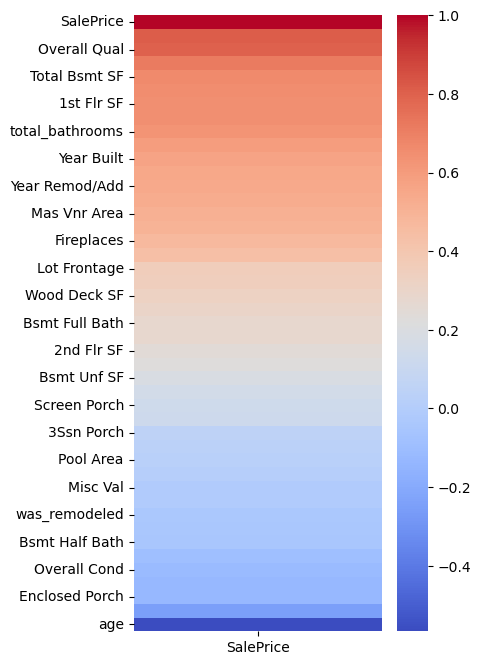

In [65]:
# Corr heatmap
fig, ax = plt.subplots()
fig.set_size_inches(4,8)
sns.heatmap(sp_corr2, cmap='coolwarm')

In [66]:
# This reveals to us the leading correlated features we should consider including in model

In [67]:
sp_corr2.index

Index(['SalePrice', 'total_sq_ft', 'Overall Qual', 'Gr Liv Area',
       'Total Bsmt SF', 'Garage Area', '1st Flr SF', 'Garage Cars',
       'total_bathrooms', 'is_new', 'Year Built', 'Garage Yr Blt',
       'Year Remod/Add', 'Full Bath', 'Mas Vnr Area', 'TotRms AbvGrd',
       'Fireplaces', 'BsmtFin SF 1', 'Lot Frontage', 'Open Porch SF',
       'Wood Deck SF', 'Lot Area', 'Bsmt Full Bath', 'Half Bath', '2nd Flr SF',
       'has_garage', 'Bsmt Unf SF', 'has_basement', 'Screen Porch',
       'Bedroom AbvGr', '3Ssn Porch', 'Mo Sold', 'Pool Area', 'BsmtFin SF 2',
       'Misc Val', 'Yr Sold', 'was_remodeled', 'Low Qual Fin SF',
       'Bsmt Half Bath', 'MS SubClass', 'Overall Cond', 'Kitchen AbvGr',
       'Enclosed Porch', 'PID', 'age'],
      dtype='object')

### What Numerical columns are better suited to be categorical?

In [68]:
nm1 = train2.select_dtypes(include = [np.number])

<Figure size 2000x700 with 0 Axes>

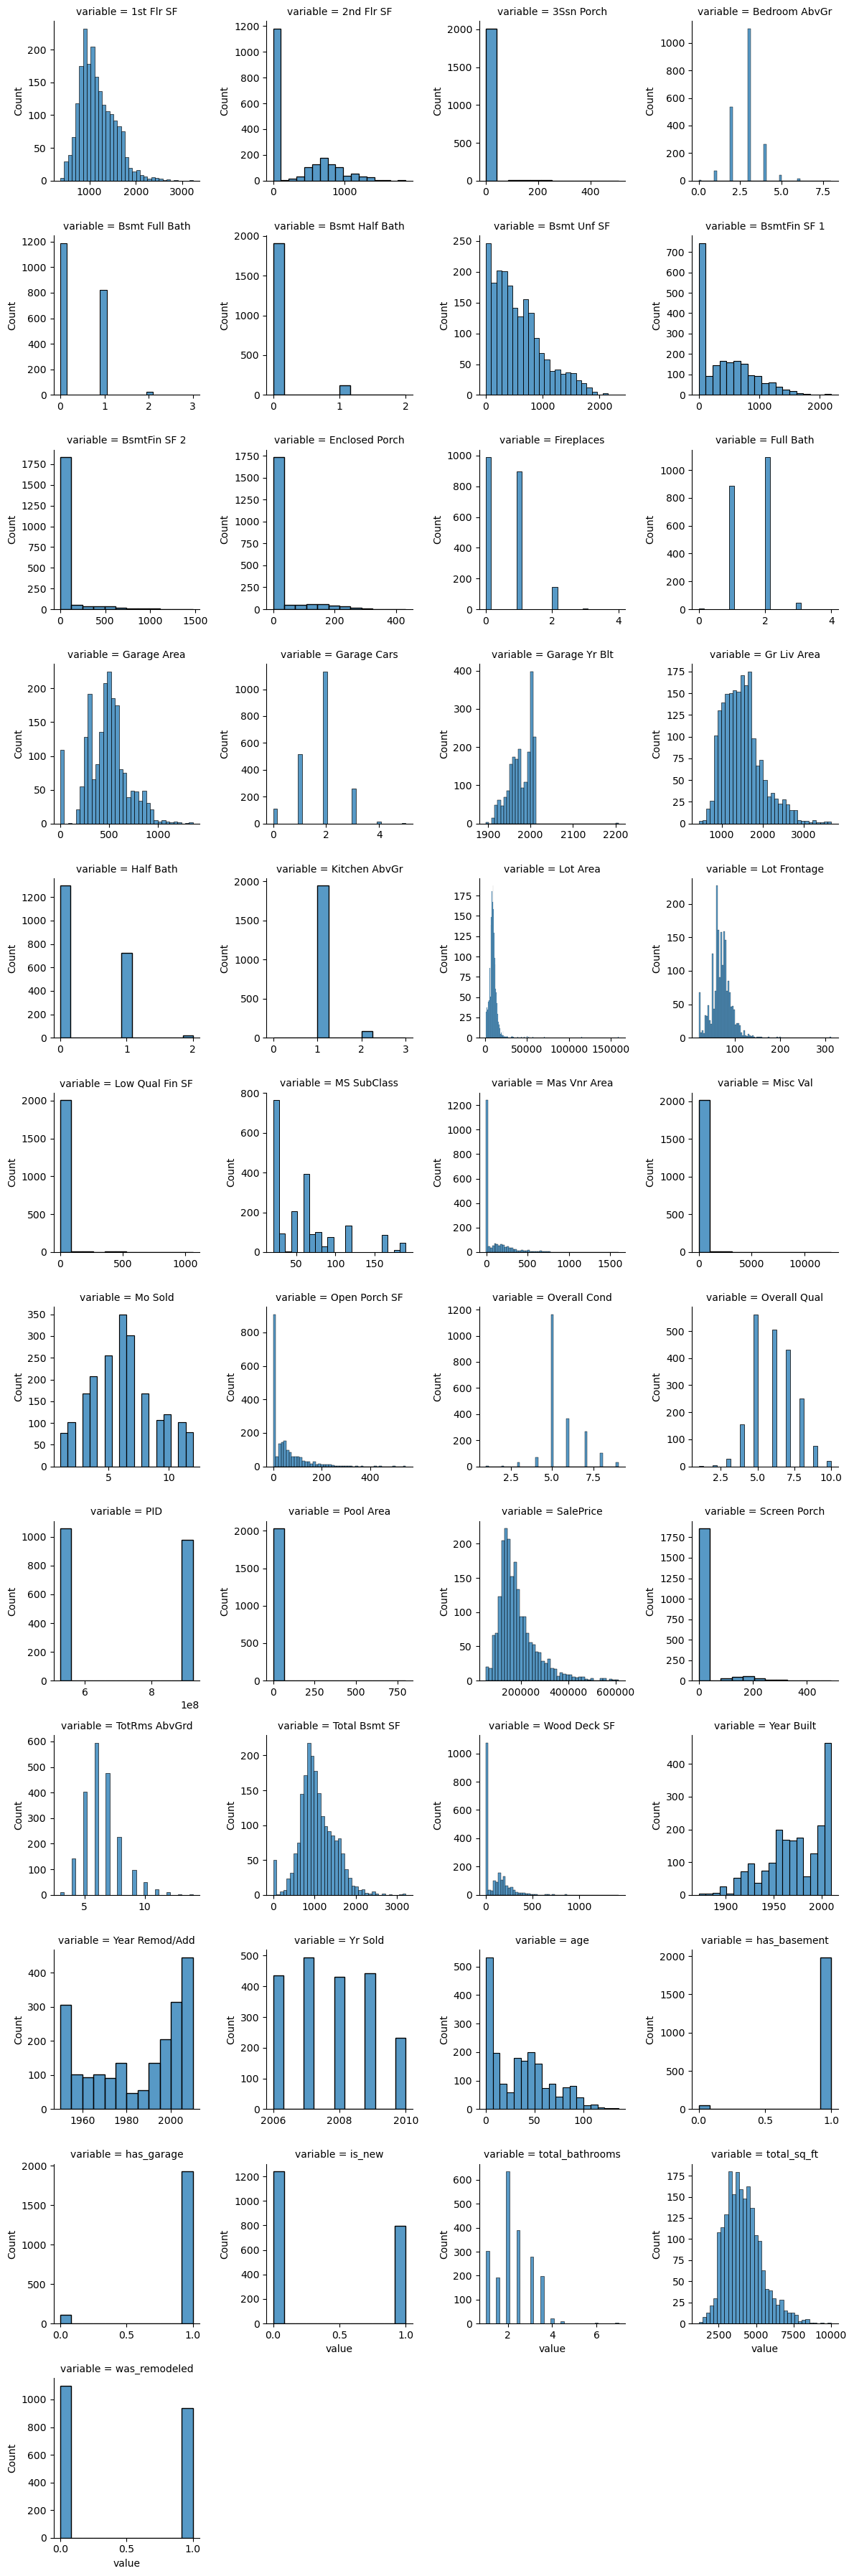

In [69]:
d = pd.melt(train2, value_vars = sorted(nm1))

plt.figure(figsize = (20,7))
e = sns.FacetGrid(d, 
                 col = 'variable',
                 col_wrap=4,
                 sharex=False, sharey=False)
e = e.map(sns.histplot, 'value')
e.fig.tight_layout()

#### A few numeric variables stand out as being better suited for categorical type.

#### Adjusting this will allow the model to learn better since these are not continuous values but rather discrete values

In [70]:
nm1.columns

Index(['PID', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces',
       'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
       'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'SalePrice', 'age',
       'total_sq_ft', 'has_basement', 'has_garage', 'was_remodeled', 'is_new',
       'total_bathrooms'],
      dtype='object')

In [71]:
num_to_cat = [
'Bedroom AbvGr',
'Bsmt Full Bath',
'Bsmt Half Bath',
'Fireplaces',
'Full Bath',
'Garage Cars',
'Half Bath',
'Kitchen AbvGr',
'Mo Sold',
'Overall Cond',
'Overall Qual',
'PID',
'TotRms AbvGrd',
'Year Remod/Add',
'Yr Sold',
'has_basement',
'has_garage',
'is_new',
'total_bathrooms',
'was_remodeled',
]

In [72]:
# Define a function to pass a list of column names and transform them from numeric to categorical (object)
def objmaker(df, u):
    for i in u:
        df[u] = df[u].astype(str)
    return

In [73]:
# Starting point - check data type before running function
train2.dtypes

PID                  int64
MS SubClass          int64
MS Zoning           object
Lot Frontage       float64
Lot Area             int64
Street              object
Lot Shape           object
Land Contour        object
Utilities           object
Lot Config          object
Land Slope          object
Neighborhood        object
Condition 1         object
Condition 2         object
Bldg Type           object
House Style         object
Overall Qual         int64
Overall Cond         int64
Year Built           int64
Year Remod/Add       int64
Roof Style          object
Roof Matl           object
Exterior 1st        object
Exterior 2nd        object
Mas Vnr Type        object
Mas Vnr Area       float64
Exter Qual          object
Exter Cond          object
Foundation          object
Bsmt Qual           object
Bsmt Cond           object
Bsmt Exposure       object
BsmtFin Type 1      object
BsmtFin SF 1       float64
BsmtFin Type 2      object
BsmtFin SF 2       float64
Bsmt Unf SF        float64
T

In [74]:
# Run numeric to categorical function
objmaker(mega2, num_to_cat)
objmaker(train2, num_to_cat)
objmaker(test2, num_to_cat)

In [75]:
# force decimal format then str format for alignment
mega2['Garage Cars'] = mega2['Garage Cars'].astype(np.float64)
mega2['Garage Cars'] = mega2['Garage Cars'].astype(str)

train2['Garage Cars'] = train2['Garage Cars'].astype(np.float64)
train2['Garage Cars'] = train2['Garage Cars'].astype(str)

test2['Garage Cars'] = test2['Garage Cars'].astype(np.float64) 
test2['Garage Cars'] = test2['Garage Cars'].astype(str)

In [76]:
train2.isna().sum().sum()

3

In [77]:
# Impute the NaNs in dataframe
imp2 = NaNImputer(train_sample_size=999_999, # I want to use entire dataset to train therefore I have intently set samp size to a high number
                  verbose = True)

mega3 = imp2.impute(train=True,
                     data=mega2)


 * Initiating NaNImputer.impute
     . Dataset dimensions:
     .. rows:         2929
     .. columns:      85
     .. mb in memory: 1.97
     .. NaN cols num: 1

   - Drop hopeless NaN cols

   - Processing whole data for imputation
     . Processed 10 cols; 49 to go
     . Processed 20 cols; 39 to go
     . Processed 30 cols; 29 to go
     . Processed 40 cols; 19 to go
     . Processed 50 cols; 9 to go

   - Imputing single core 1 cols
     . Imputed (multiclass) - 3        NaN in neigh_rank

   - Missing values after imputation: 0

Time elapsed for impute execution: 0.653 seconds


In [78]:
train3 = imp2.impute(train=False,
                     data=train2)


 * Initiating NaNImputer.impute
     . Dataset dimensions:
     .. rows:         2036
     .. columns:      85
     .. mb in memory: 1.39
     .. NaN cols num: 1

   - Drop hopeless NaN cols

   - Processing whole data for imputation
     . Processed 10 cols; 49 to go
     . Processed 20 cols; 39 to go
     . Processed 30 cols; 29 to go
     . Processed 40 cols; 19 to go
     . Processed 50 cols; 9 to go

   - Imputing single core 1 cols
     . Imputed (multiclass) - 3        NaN in neigh_rank

   - Missing values after imputation: 0

Time elapsed for impute execution: 0.557 seconds


In [79]:
mega2 = mega3.copy()
train2 = train3.copy()

### Apply Log to coerce normal distribution

In [80]:
a1 = mega2.select_dtypes(include = [np.number])
a1_col = a1.columns

b1 = mega2.select_dtypes(exclude = [np.number])
b1_col = b1.columns

In [81]:
a1_col

Index(['MS SubClass', 'Lot Frontage', 'Lot Area', 'Year Built', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Garage Yr Blt', 'Garage Area', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val',
       'SalePrice', 'age', 'total_sq_ft'],
      dtype='object')

In [82]:
# Apply log to numerical features to coerce and approximate normal distribution
for f in a1_col:
    train2.loc[:,f] = np.log1p(train2[f])

In [83]:
for f in a1_col:
    mega2.loc[:,f] = np.log1p(mega2[f])

In [84]:
# Remove saleprice from list that will be applied to test dataset
a1_col_b = ['MS SubClass', 'Lot Frontage', 'Lot Area', 'Year Built', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Garage Yr Blt', 'Garage Area', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'age', 'total_sq_ft']

In [85]:
for f in a1_col_b:
    test2.loc[:,f] = np.log1p(test2[f])

<AxesSubplot: xlabel='SalePrice', ylabel='Count'>

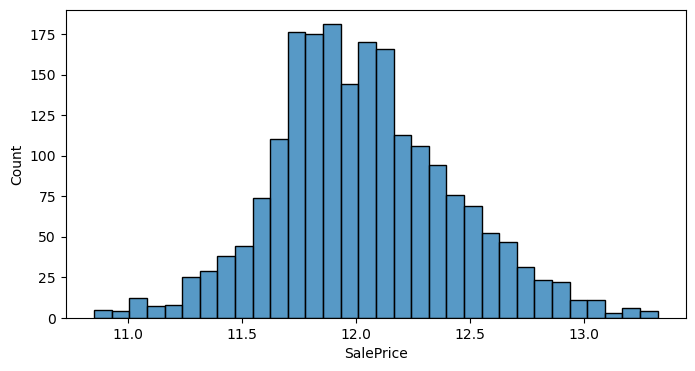

In [86]:
# Checking SalePrice distribution approximates normal
plt.figure(figsize = (8,4))
sns.histplot(train2['SalePrice'])

In [87]:
# Nice target distribution!

### Encode Categorical data

In [88]:
# Determine which categorical data should be nominal vs ordinal
b1_col

Index(['PID', 'MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Remod/Add', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Bsmt Full Bath', 'Bsmt Half Bath',
       'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr',
       'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces',
       'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Cars',
       'Garage Qual', 'Garage Cond', 'Paved Drive', 'Mo Sold', 'Yr Sold',
       'Sale Type', 'isTrain', 'neigh_rank', 'has_basement', 'has_garage',
       'was_remodeled', 'is_new', 'total_bathrooms'],
      dtype='object')

In [89]:
# Create list of nominal vs ordinal categorical features for most significant
# Note Neighborhood data has already been addressed

cat_nom_list = ['Foundation',
                'Garage Type',
                'Mas Vnr Type',
                'Exterior 1st']

cat_ord_list = ['Exter Qual',
                'Kitchen Qual',
                'Bsmt Qual',
                'Garage Finish',
                'BsmtFin Type 1',
                'Heating QC',
                'Bsmt Exposure',
               'Garage Cars']

In [90]:
# Of the features that were transformed from numerical to categorical which are ordinal
num_to_cat

['Bedroom AbvGr',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Fireplaces',
 'Full Bath',
 'Garage Cars',
 'Half Bath',
 'Kitchen AbvGr',
 'Mo Sold',
 'Overall Cond',
 'Overall Qual',
 'PID',
 'TotRms AbvGrd',
 'Year Remod/Add',
 'Yr Sold',
 'has_basement',
 'has_garage',
 'is_new',
 'total_bathrooms',
 'was_remodeled']

In [91]:
n2c_ord = ['Bedroom AbvGr',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Fireplaces',
 'Full Bath',
 'Garage Cars',
 'Half Bath',
 'Kitchen AbvGr',
 'Overall Cond',
 'Overall Qual',
'TotRms AbvGrd',           
'has_basement',
 'has_garage',
 'is_new',
 'total_bathrooms',
 'was_remodeled']


n2c_nom = ['Mo Sold',
           'PID',
           'Year Remod/Add',
           'Yr Sold']           

In [92]:
c_nom_f = ['Foundation',
           'Garage Type',
           'Mas Vnr Type',
           'Exterior 1st',
           'Mo Sold',
           'PID',
           'Year Remod/Add',
           'Yr Sold']

c_ord_f = ['Exter Qual',
                'Kitchen Qual',
                'Bsmt Qual',
                'Garage Finish',
                'BsmtFin Type 1',
                'Heating QC',
                'Bsmt Exposure',
           'Bedroom AbvGr',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Fireplaces',
 'Full Bath',
 'Garage Cars',
 'Half Bath',
 'Kitchen AbvGr',
 'Overall Cond',
 'Overall Qual',
'TotRms AbvGrd',           
'has_basement',
 'has_garage',
 'is_new',
 'total_bathrooms',
 'was_remodeled',
 'Exter Cond']
           
c_other_f = ['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style',
       'Roof Style', 'Roof Matl',
       'Exterior 2nd', 'Bsmt Cond', 'BsmtFin Type 2', 'Heating',
       'Central Air', 'Electrical', 'Functional', 'Fireplace Qu',
             'Garage Qual', 'Garage Cond', 'Paved Drive']

### Ordinal Encoding

In [93]:
# Create list of ordinal rankings to pass into OrdinalEncoder (only for key variables)
standard1 = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
number_alignment = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
gar_cars = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0']
exposure = ['NA', 'No', 'Mn', 'Av', 'Gd']
fin_type = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
gar_fin = ['NA', 'Unf', 'RFn', 'Fin']

In [94]:
# Create lists of columns that correspond to the ordinal rankings we just created

stand_col = ['Exter Qual',
            'Exter Cond',
            'Bsmt Qual',
            'Bsmt Cond',
            'Heating QC',
            'Kitchen Qual',
            'Fireplace Qu',
            'Garage Qual',
            'Garage Cond']

num_ali_col = ['Overall Qual',
               'Overall Cond']

gar_car_col  = ['Garage Cars']

exp_col = ['Bsmt Exposure']

fin_type_col = ['BsmtFin Type 1',
                'BsmtFin Type 2']

gar_fin_col = ['Garage Finish']

In [95]:
ord1 = OrdinalEncoder(categories=[standard1,
                                  standard1,
                                  standard1,
                                  standard1,
                                  standard1,
                                  standard1,
                                  standard1,
                                  standard1,
                                  standard1,
                                  number_alignment,
                                  number_alignment,
                                  gar_cars,
                                  exposure,
                                  fin_type,
                                  fin_type,
                                  gar_fin])

In [96]:
mega2[['Exter Qual',
            'Exter Cond',
            'Bsmt Qual',
            'Bsmt Cond',
            'Heating QC',
            'Kitchen Qual',
            'Fireplace Qu',
            'Garage Qual',
            'Garage Cond',
       'Overall Qual',
       'Overall Cond',
       'Garage Cars',
       'Bsmt Exposure',
       'BsmtFin Type 1',  
       'BsmtFin Type 2',
            'Garage Finish']] = ord1.fit_transform(mega2[['Exter Qual',
            'Exter Cond',
            'Bsmt Qual',
            'Bsmt Cond',
            'Heating QC',
            'Kitchen Qual',
            'Fireplace Qu',
            'Garage Qual',
            'Garage Cond',
            'Overall Qual',
            'Overall Cond',
            'Garage Cars',
            'Bsmt Exposure',
            'BsmtFin Type 1',
            'BsmtFin Type 2',
            'Garage Finish']])

In [97]:
train2[['Exter Qual',
            'Exter Cond',
            'Bsmt Qual',
            'Bsmt Cond',
            'Heating QC',
            'Kitchen Qual',
            'Fireplace Qu',
            'Garage Qual',
            'Garage Cond',
       'Overall Qual',
       'Overall Cond',
       'Garage Cars',
       'Bsmt Exposure',
       'BsmtFin Type 1',  
       'BsmtFin Type 2',
            'Garage Finish']] = ord1.transform(train2[['Exter Qual',
            'Exter Cond',
            'Bsmt Qual',
            'Bsmt Cond',
            'Heating QC',
            'Kitchen Qual',
            'Fireplace Qu',
            'Garage Qual',
            'Garage Cond',
            'Overall Qual',
            'Overall Cond',
            'Garage Cars',
            'Bsmt Exposure',
            'BsmtFin Type 1',
            'BsmtFin Type 2',
            'Garage Finish']])

In [98]:
test2[['Exter Qual',
            'Exter Cond',
            'Bsmt Qual',
            'Bsmt Cond',
            'Heating QC',
            'Kitchen Qual',
            'Fireplace Qu',
            'Garage Qual',
            'Garage Cond',
       'Overall Qual',
       'Overall Cond',
       'Garage Cars',
       'Bsmt Exposure',
       'BsmtFin Type 1',  
       'BsmtFin Type 2',
            'Garage Finish']] = ord1.transform(test2[['Exter Qual',
            'Exter Cond',
            'Bsmt Qual',
            'Bsmt Cond',
            'Heating QC',
            'Kitchen Qual',
            'Fireplace Qu',
            'Garage Qual',
            'Garage Cond',
            'Overall Qual',
            'Overall Cond',
            'Garage Cars',
            'Bsmt Exposure',
            'BsmtFin Type 1',
            'BsmtFin Type 2',
            'Garage Finish']])

### Encode Nominal categoricals

In [99]:
b2 = mega2.select_dtypes(exclude = [np.number])
nominal_cat_list = b2.columns

In [100]:
enc1 = LabelEncoder()

In [101]:
for col in nominal_cat_list:
    enc1.fit(mega2[col]) # fit on combined data set, then transform
    mega2[col] = enc1.transform(mega2[col])
    train2[col] = enc1.transform(train2[col])
    test2[col] = enc1.transform(test2[col])

In [102]:
train2.isna().sum().sum()

5

In [103]:
# Impute the NaNs in dataframe
imp3 = NaNImputer(train_sample_size=999_999, # I want to use entire dataset to train therefore I have intently set samp size to a high number
                  verbose = True)

mega3 = imp3.impute(train=True,
                     data=mega2)


 * Initiating NaNImputer.impute
     . Dataset dimensions:
     .. rows:         2929
     .. columns:      85
     .. mb in memory: 1.5
     .. NaN cols num: 2

   - Drop hopeless NaN cols

   - Processing whole data for imputation

   - Imputing single core 2 cols
     . Imputed (regression) - 1        NaN in Mas Vnr Area
     . Imputed (regression) - 1        NaN in BsmtFin SF 1

   - Missing values after imputation: 0

Time elapsed for impute execution: 0.607 seconds


In [104]:
train3 = imp3.impute(train=False,
                     data=train2)


 * Initiating NaNImputer.impute
     . Dataset dimensions:
     .. rows:         2036
     .. columns:      85
     .. mb in memory: 1.06
     .. NaN cols num: 1

   - Drop hopeless NaN cols

   - Processing whole data for imputation

   - Imputing single core 1 cols
     . Imputed (regression) - 5        NaN in Mas Vnr Area

   - Missing values after imputation: 0

Time elapsed for impute execution: 0.315 seconds


In [105]:
test3 = imp3.impute(train=False,
                     data=test2)


 * Initiating NaNImputer.impute
     . Dataset dimensions:
     .. rows:         878
     .. columns:      84
     .. mb in memory: 0.46
     .. NaN cols num: 1

   - Drop hopeless NaN cols

   - Processing whole data for imputation

   - Imputing single core 1 cols
     . Imputed (regression) - 1        NaN in Mas Vnr Area

   - Missing values after imputation: 0

Time elapsed for impute execution: 0.314 seconds


In [106]:
mega2 = mega3.copy()
train2 = train3.copy()
test2 = test3.copy()

In [107]:
# All columns are now numerical

In [108]:
# Check correlations

# Segment data between numeric and object
nd4 = train2.select_dtypes(include = [np.number])

# Create list of columns (e.g. num2.columns, obj2.columns)
num_features = nd4.columns

# Evaluate correlation
nd4_corr = nd4.corr()
sp_corr4 = pd.DataFrame(nd4_corr['SalePrice'].sort_values(ascending=False))
sp_corr4

,SalePrice
SalePrice,1.000000
Overall Qual,0.824021
total_sq_ft,0.810676
Gr Liv Area,0.727781
neigh_rank,0.720611
Exter Qual,0.703613
Kitchen Qual,0.694633
Bsmt Qual,0.691516
Garage Cars,0.681694
total_bathrooms,0.669316


In [109]:
# Will apply absolute value to easily obtain list of top features
corrs = pd.DataFrame((sp_corr4['SalePrice']).abs())

In [110]:
corrs = corrs.sort_values(by='SalePrice', ascending=False)

In [111]:
corrs

,SalePrice
SalePrice,1.000000
Overall Qual,0.824021
total_sq_ft,0.810676
Gr Liv Area,0.727781
neigh_rank,0.720611
Exter Qual,0.703613
Kitchen Qual,0.694633
Bsmt Qual,0.691516
Garage Cars,0.681694
total_bathrooms,0.669316


In [112]:
# Obtain list of top 20 most correlated
corrs.index[1:36]

Index(['Overall Qual', 'total_sq_ft', 'Gr Liv Area', 'neigh_rank',
       'Exter Qual', 'Kitchen Qual', 'Bsmt Qual', 'Garage Cars',
       'total_bathrooms', 'age', 'is_new', 'Year Built', '1st Flr SF',
       'Garage Yr Blt', 'Year Remod/Add', 'Garage Finish', 'Full Bath',
       'Fireplaces', 'Heating QC', 'Open Porch SF', 'Garage Type',
       'Mas Vnr Area', 'Foundation', 'Garage Area', 'Bsmt Exposure',
       'Total Bsmt SF', 'Lot Area', 'BsmtFin Type 1', 'Paved Drive',
       'Wood Deck SF', 'Lot Frontage', 'Central Air', 'Lot Shape', 'PID',
       'Half Bath'],
      dtype='object')

In [113]:
high_corr = list(corrs.index[1:21])
high_corr

['Overall Qual',
 'total_sq_ft',
 'Gr Liv Area',
 'neigh_rank',
 'Exter Qual',
 'Kitchen Qual',
 'Bsmt Qual',
 'Garage Cars',
 'total_bathrooms',
 'age',
 'is_new',
 'Year Built',
 '1st Flr SF',
 'Garage Yr Blt',
 'Year Remod/Add',
 'Garage Finish',
 'Full Bath',
 'Fireplaces',
 'Heating QC',
 'Open Porch SF']

In [114]:
# List of overall features to include in modeling
features = ['Overall Qual', 'total_sq_ft', 'Gr Liv Area', 'neigh_rank',
       'Exter Qual', 'Kitchen Qual', 'Bsmt Qual', 'Garage Cars',
       'total_bathrooms', 'is_new', 'Year Built', '1st Flr SF',
       'Garage Yr Blt', 'Year Remod/Add', 'Garage Finish', 'Full Bath',
       'Fireplaces', 'Heating QC', 'Open Porch SF', 'Mas Vnr Area',
       'Foundation', 'Garage Area', 'Bsmt Exposure', 'Lot Area',
       'BsmtFin Type 1', 'Total Bsmt SF', 'Paved Drive', 'Wood Deck SF',
       'Lot Frontage', 'Central Air', 'Half Bath', 'has_garage',
       'Bsmt Full Bath', 'Electrical', 'BsmtFin SF 1', 'Garage Qual',
       'Bsmt Cond', 'Roof Style', 'House Style', 'Neighborhood',
       'has_basement', 'Garage Cond', 'Bsmt Unf SF', 'Bedroom AbvGr',
       'Functional', 'Exterior 2nd', '2nd Flr SF', 'Screen Porch',
       'Exterior 1st', 'TotRms AbvGrd', 'Fireplace Qu', 'Condition 1',
       'Street', 'Roof Matl', '3Ssn Porch', 'Land Slope', 'Exter Cond',
       'Condition 2', 'Pool Area', 'Mo Sold', 'Sale Type',
       'BsmtFin Type 2', 'Utilities', 'Yr Sold', 'Land Contour',
       'BsmtFin SF 2', 'Bsmt Half Bath', 'Bldg Type', 'Misc Val',
       'MS SubClass', 'Lot Config', 'Mas Vnr Type', 'Overall Cond',
       'Low Qual Fin SF', 'was_remodeled', 'Heating', 'Kitchen AbvGr',
       'Enclosed Porch', 'MS Zoning', 'Lot Shape', 'Garage Type',
       'age']            

In [115]:
# List of non_encoded features for scaling
Non_enc_features = ['total_sq_ft',
                    'Gr Liv Area',
                    '1st Flr SF',
                    'Open Porch SF',
                    'Garage Area', # not in high corr list
                    'Lot Area', # not in high corr list
                    'Total Bsmt SF'] # not in high corr list

In [116]:
# Create list of encoded features
enc_features = []

for i in features:
    if i not in Non_enc_features:
        enc_features.append(i)

### Preparation & Scaling

In [120]:
train_temp = train2.copy()

train_temp.drop('SalePrice', axis=1, inplace=True)

In [121]:
# Set target
y = train2['SalePrice']

# Establish workhorse dataset
X = train_temp[features]

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.32, random_state=42)

In [123]:
print('Check Shapes:')
print('X_train:', X_train.shape)
print('X_val:', X_test.shape)
print('y_train:', y_train.shape)
print('y_val:', y_test.shape)

Check Shapes:
X_train: (1384, 82)
X_val: (652, 82)
y_train: (1384,)
y_val: (652,)


In [124]:
# Alignment due dilligence
X_train.sort_index(inplace=True)
X_test.sort_index(inplace=True)
y_train.sort_index(inplace=True)
y_test.sort_index(inplace=True)
test2.sort_index(inplace=True)

In [125]:
rs = RobustScaler()

In [126]:
# Fit scaler to combined dataset since it will presents a better perspective on feature distribution (than train alone)
rs.fit(mega2[Non_enc_features])

RobustScaler()

In [127]:
Z_train = pd.DataFrame(rs.transform(X_train[Non_enc_features]), columns=Non_enc_features, index=X_train.index)
Z_test = pd.DataFrame(rs.transform(X_test[Non_enc_features]), columns=Non_enc_features, index=X_test.index)

In [128]:
zx_train = pd.concat([X_train[enc_features], Z_train[Non_enc_features]],
                     axis=1,
                     verify_integrity=True,
                     sort=True)

X_train.shape, Z_train.shape, zx_train.shape

((1384, 82), (1384, 7), (1384, 82))

In [129]:
zx_test = pd.concat([X_test[enc_features], Z_test[Non_enc_features]],
                     axis=1,
                     verify_integrity=True,
                     sort=True)

X_test.shape, Z_test.shape, zx_test.shape

((652, 82), (652, 7), (652, 82))

In [130]:
# Train datasets have been processed, Next is test
W = test2[features].copy()

# Transform w/ RobustScaler
W_interim = pd.DataFrame(rs.transform(W[Non_enc_features]), columns=Non_enc_features, index=W.index)

W_final = pd.concat([W[enc_features], W_interim[Non_enc_features]],
                     axis=1,
                     verify_integrity=True,
                     sort=True)

W_final.sort_index(inplace=True)

### Define Scoring Metrics

In [131]:
def rsme_train(model):
    cv_scores0 = np.sqrt(-cross_val_score(model, zx_train, y_train, scoring='neg_mean_squared_error', cv=3))
    return np.mean(cv_scores0)

def rsme_test(model):
    cv_scores1 = np.sqrt(-cross_val_score(model, zx_test, y_test, scoring='neg_mean_squared_error', cv=3))
    return np.mean(cv_scores1)

def rmse(model):
    print('Train RMSE: {:.5f} | Test RMSE: {:.5f}'.format(rsme_train(model), rsme_test(model)))

In [132]:
# XGBoost Scoring

def xgb_rmse(model):
    y_pred_train = model.predict(zx_train)
    xscore1 = np.sqrt(mean_squared_error(y_train, y_pred_train))
    
    y_pred_test = model.predict(zx_test)
    xscore2 = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    print('XGBoost Train RMSE: {:.5f} | Test RMSE: {:.5f}'.format(xscore1, xscore2))

### Lasso

In [133]:
param_grid = {'alpha': [0.0005, 0.0001, 0.001, 0.01, 0.1, 1], 'max_iter': [50_000]}

lasso = GridSearchCV(Lasso(), cv=5, param_grid = param_grid, scoring = 'neg_mean_squared_error')
lasso.fit(zx_train, y_train)

alpha = lasso.best_params_['alpha']
lasso = lasso.best_estimator_

print('Lasso --> Train RMSE: {:.5f} | Test RMSE: {:.5f} | alpha: {:.5f}'.format(rsme_train(lasso), rsme_test(lasso), alpha))

Lasso --> Train RMSE: 0.11243 | Test RMSE: 0.11016 | alpha: 0.00100


In [134]:
rmse(lasso)

Train RMSE: 0.11243 | Test RMSE: 0.11016


In [135]:
# Coefficients output preparation
coefs = pd.DataFrame({'coefs':lasso.coef_, 'Positive': lasso.coef_ > 0}, index= zx_train.columns)
coefs['coefs_abs'] = np.abs(coefs.coefs)

top_coefs = coefs.sort_values('coefs_abs', ascending=False)

top_coefs
# Note that these values are still affected by log. Would have to reverse them for final values, nevertheless this still hones in on key coefs/features

,coefs,Positive,coefs_abs
total_sq_ft,0.133072,True,0.133072
Gr Liv Area,0.063233,True,0.063233
Kitchen AbvGr,-0.055202,False,0.055202
Overall Qual,0.055111,True,0.055111
Overall Cond,0.041375,True,0.041375
Lot Area,0.040514,True,0.040514
age,-0.040408,False,0.040408
neigh_rank,0.033263,True,0.033263
Fireplaces,0.030626,True,0.030626
Garage Cars,0.029132,True,0.029132


In [136]:
zx_train_bkup = zx_train.copy()
zx_test_bkup = zx_test.copy()

zx_train = zx_train[top_coefs.index].copy()
zx_test = zx_test[top_coefs.index].copy()

### XGBoost

In [137]:
xgb1 = xgb.XGBRegressor(n_estimators=10000,
                        seed=42,
                        eval_metric='rmse',
                        random_state=42,
                        tree_method='gpu_hist',
                        gpu_id=0,
                        predictor='gpu_predictor',
                        n_jobs=-1,
                        early_stopping_rounds=500, # ensure get out of SGD local minimas
                        learning_rate=.01)

In [138]:
xgb1.fit(zx_train, y_train,
        eval_set=[(zx_train, y_train), (zx_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:11.42677	validation_1-rmse:11.42126
[100]	validation_0-rmse:4.19575	validation_1-rmse:4.18702
[200]	validation_0-rmse:1.54837	validation_1-rmse:1.53988
[300]	validation_0-rmse:0.58067	validation_1-rmse:0.57757
[400]	validation_0-rmse:0.22978	validation_1-rmse:0.23843
[500]	validation_0-rmse:0.10838	validation_1-rmse:0.13515
[600]	validation_0-rmse:0.06977	validation_1-rmse:0.11186
[700]	validation_0-rmse:0.05729	validation_1-rmse:0.10705
[800]	validation_0-rmse:0.05106	validation_1-rmse:0.10574
[900]	validation_0-rmse:0.04681	validation_1-rmse:0.10509
[1000]	validation_0-rmse:0.04353	validation_1-rmse:0.10472
[1100]	validation_0-rmse:0.04057	validation_1-rmse:0.10451
[1200]	validation_0-rmse:0.03804	validation_1-rmse:0.10449
[1300]	validation_0-rmse:0.03596	validation_1-rmse:0.10452
[1400]	validation_0-rmse:0.03381	validation_1-rmse:0.10446
[1500]	validation_0-rmse:0.03201	validation_1-rmse:0.10447
[1600]	validation_0-rmse:0.03040	validation_1-rmse:0.10441
[1700]	

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=500, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=0, gpu_id=0,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=-1,
             num_parallel_tree=1, predictor='gpu_predictor', random_state=42, ...)

In [139]:
xgb_rmse(xgb1)

XGBoost Train RMSE: 0.01897 | Test RMSE: 0.10385


#### XGBoost Round 2

In [140]:
# Tune
xgb2 = xgb.XGBRegressor(colsample_bytree=0.20,
                        tree_method='gpu_hist',
                        eval_metric='rmse',
                        gpu_id=0,
                        predictor='gpu_predictor',
                        gamma = 0,
                        learning_rate = .0010,
                        max_depth=5,
                        min_child_weight=3.75,
                        n_estimators=26500,
                        reg_alpha=0.1,
                        reg_lambda=0.777,
                        subsample=0.888,
                        seed=42,
                        random_state=42,
                        n_jobs=-1,
                       )

xgb2.fit(zx_train, y_train,
        eval_set=[(zx_train, y_train), (zx_test, y_test)],
         verbose=500)

[0]	validation_0-rmse:11.53045	validation_1-rmse:11.52495
[500]	validation_0-rmse:7.00016	validation_1-rmse:6.99291
[1000]	validation_0-rmse:4.25263	validation_1-rmse:4.24423
[1500]	validation_0-rmse:2.58669	validation_1-rmse:2.57773
[2000]	validation_0-rmse:1.57682	validation_1-rmse:1.56730
[2500]	validation_0-rmse:0.96535	validation_1-rmse:0.95589
[3000]	validation_0-rmse:0.59614	validation_1-rmse:0.58774
[3500]	validation_0-rmse:0.37451	validation_1-rmse:0.36827
[4000]	validation_0-rmse:0.24363	validation_1-rmse:0.24078
[4500]	validation_0-rmse:0.16856	validation_1-rmse:0.17033
[5000]	validation_0-rmse:0.12743	validation_1-rmse:0.13454
[5500]	validation_0-rmse:0.10581	validation_1-rmse:0.11776
[6000]	validation_0-rmse:0.09450	validation_1-rmse:0.11029
[6500]	validation_0-rmse:0.08796	validation_1-rmse:0.10661
[7000]	validation_0-rmse:0.08360	validation_1-rmse:0.10463
[7500]	validation_0-rmse:0.08032	validation_1-rmse:0.10344
[8000]	validation_0-rmse:0.07758	validation_1-rmse:0.10253

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.2,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=0, gpu_id=0,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.001, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=3.75, missing=nan,
             monotone_constraints='()', n_estimators=26500, n_jobs=-1,
             num_parallel_tree=1, predictor='gpu_predictor', random_state=42, ...)

In [141]:
xgb_rmse(xgb2)

XGBoost Train RMSE: 0.03514 | Test RMSE: 0.09711


### XGB 3

In [142]:
xgb3 = xgb.XGBRegressor(colsample_bytree=0.4603,
                        tree_method='gpu_hist',
                        eval_metric='rmse',
                        gpu_id=0,
                        predictor='gpu_predictor',
                        gamma=0.0468,
                        learning_rate=0.01,
                        max_depth=5,
                        min_child_weight=1.7817,
                        n_estimators=100_000,
                        reg_alpha=0.05,
                        reg_lambda=0.8571,
                        subsample=0.5213,
                        random_state =42,
                        n_jobs = -1,
                        early_stopping_rounds=500)

In [143]:
xgb3.fit(zx_train, y_train,
        eval_set=[(zx_train, y_train), (zx_test[top_coefs.index], y_test)],
        verbose=500)

[0]	validation_0-rmse:11.42672	validation_1-rmse:11.42121
[500]	validation_0-rmse:0.12541	validation_1-rmse:0.13453
[1000]	validation_0-rmse:0.07940	validation_1-rmse:0.10247
[1500]	validation_0-rmse:0.07735	validation_1-rmse:0.10141
[2000]	validation_0-rmse:0.07637	validation_1-rmse:0.10085
[2500]	validation_0-rmse:0.07564	validation_1-rmse:0.10065
[3000]	validation_0-rmse:0.07524	validation_1-rmse:0.10036
[3500]	validation_0-rmse:0.07488	validation_1-rmse:0.10030
[4000]	validation_0-rmse:0.07466	validation_1-rmse:0.10011
[4500]	validation_0-rmse:0.07442	validation_1-rmse:0.09998
[5000]	validation_0-rmse:0.07427	validation_1-rmse:0.09987
[5500]	validation_0-rmse:0.07406	validation_1-rmse:0.09970
[6000]	validation_0-rmse:0.07389	validation_1-rmse:0.09966
[6378]	validation_0-rmse:0.07377	validation_1-rmse:0.09964


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4603,
             early_stopping_rounds=500, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=0.0468, gpu_id=0,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=1.7817, missing=nan,
             monotone_constraints='()', n_estimators=100000, n_jobs=-1,
             num_parallel_tree=1, predictor='gpu_predictor', random_state=42, ...)

In [144]:
xgb_rmse(xgb3)

XGBoost Train RMSE: 0.07394 | Test RMSE: 0.09963


### XGB 4

In [145]:
# Tune 4
xgb4 = xgb.XGBRegressor(colsample_bytree=0.05,
                        eval_metric='rmse',
                        tree_method='gpu_hist',
                        gpu_id=0,
                        predictor='gpu_predictor',
                        gamma = 0.2,
                        learning_rate = .007,
                        max_depth=5,
                        min_child_weight=4.2,
                        n_estimators=500_000,
                        reg_alpha=0.3,
                        reg_lambda=0.9,
                        subsample=0.45,
                        seed=42,
                        random_state=42,
                        n_jobs=-1,
                        early_stopping_rounds=1000) # ensure get out of SGD local minimas

xgb4.fit(zx_train, y_train,
        eval_set=[(zx_train, y_train), (zx_test, y_test)],
         verbose=2000)

[0]	validation_0-rmse:11.46130	validation_1-rmse:11.45579
[2000]	validation_0-rmse:0.11546	validation_1-rmse:0.11435
[4000]	validation_0-rmse:0.10982	validation_1-rmse:0.10950
[6000]	validation_0-rmse:0.10789	validation_1-rmse:0.10785
[8000]	validation_0-rmse:0.10713	validation_1-rmse:0.10728
[10000]	validation_0-rmse:0.10681	validation_1-rmse:0.10703
[12000]	validation_0-rmse:0.10633	validation_1-rmse:0.10663
[14000]	validation_0-rmse:0.10606	validation_1-rmse:0.10650
[16000]	validation_0-rmse:0.10580	validation_1-rmse:0.10631
[18000]	validation_0-rmse:0.10564	validation_1-rmse:0.10618
[20000]	validation_0-rmse:0.10552	validation_1-rmse:0.10609
[22000]	validation_0-rmse:0.10537	validation_1-rmse:0.10598
[24000]	validation_0-rmse:0.10534	validation_1-rmse:0.10596
[24082]	validation_0-rmse:0.10533	validation_1-rmse:0.10596


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.05,
             early_stopping_rounds=1000, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=0.2, gpu_id=0,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.007, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=4.2, missing=nan,
             monotone_constraints='()', n_estimators=500000, n_jobs=-1,
             num_parallel_tree=1, predictor='gpu_predictor', random_state=42, ...)

In [146]:
xgb_rmse(xgb4)

XGBoost Train RMSE: 0.10537 | Test RMSE: 0.10595


In [147]:
# XGBoost key features used
fi = pd.DataFrame(data=xgb2.feature_importances_,
             index=xgb2.feature_names_in_,
             columns=['importance']).sort_values(by='importance', ascending=False)

fi

,importance
Overall Qual,0.143851
Fireplaces,0.079984
total_sq_ft,0.072989
neigh_rank,0.068969
Kitchen Qual,0.056018
Exter Qual,0.052362
is_new,0.049971
Garage Finish,0.042465
total_bathrooms,0.038450
Garage Cars,0.036981


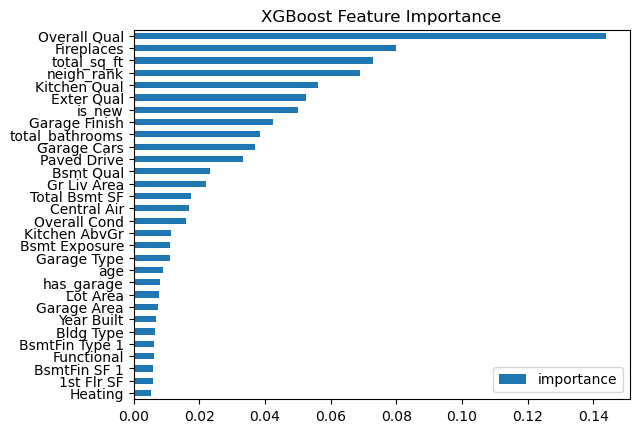

In [148]:
fi[0:30].sort_values('importance').plot(kind='barh', title='XGBoost Feature Importance')
plt.show()

### Linear Regression

In [149]:
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(zx_train, y_train)

LinearRegression(n_jobs=-1)

In [150]:
rmse(lr_model)

Train RMSE: 0.11598 | Test RMSE: 0.11447


### Random Forest Regressor

In [151]:
rfr = RandomForestRegressor(random_state=42,
                           n_estimators=420,
                           max_depth=25,
                           n_jobs=-1)
rfr.fit(zx_train, y_train)

RandomForestRegressor(max_depth=25, n_estimators=420, n_jobs=-1,
                      random_state=42)

In [152]:
rmse(rfr)

Train RMSE: 0.13013 | Test RMSE: 0.13263


### ElasticNet Regression

In [153]:
model_enet = ElasticNet(alpha = 0.0013, l1_ratio=0.94)
model_enet.fit(zx_train, y_train) 

ElasticNet(alpha=0.0013, l1_ratio=0.94)

In [154]:
rmse(model_enet)

Train RMSE: 0.11242 | Test RMSE: 0.11002


### Ridge

In [155]:
rr = Ridge(alpha=0.0013)
rr.fit(zx_train, y_train)

Ridge(alpha=0.0013)

In [156]:
rmse(rr)

Train RMSE: 0.11593 | Test RMSE: 0.11451


### Lasso

In [157]:
model_lasso = Lasso(alpha=0.0013)
model_lasso.fit(zx_train, y_train) 

Lasso(alpha=0.0013)

In [158]:
rmse(model_lasso)

Train RMSE: 0.11245 | Test RMSE: 0.10999


### Hist Grad Boost Reg

In [159]:
hgb = HistGradientBoostingRegressor(learning_rate=0.0555,
                                    random_state=42,
                                    #early_stopping=500
                                   )
hgb.fit(zx_train, y_train)
rmse(hgb)

Train RMSE: 0.12484 | Test RMSE: 0.12037


### NuSVR

In [160]:
nu1 = NuSVR(C = 18, cache_size=2048)

In [161]:
%%time
nu1.fit(zx_train, y_train)
rmse(nu1)

Train RMSE: 0.12026 | Test RMSE: 0.11735
CPU times: total: 19.9 s
Wall time: 17.6 s


### LightGBM

In [162]:
lgb1 = lgb.LGBMRegressor(objective='regression',
                         num_leaves=5,
                         learning_rate=0.05,
                         n_estimators=4200,
                         max_bin = 55,
                         bagging_fraction = 0.8,
                         bagging_freq = 5,
                         feature_fraction = 0.2319,
                         feature_fraction_seed=9,
                         bagging_seed=9,
                         min_data_in_leaf =6,
                         min_sum_hessian_in_leaf = 11,
                         lambda_l1 = 0.25,
                         random_state=42,
                         num_threads=-1,
                         device_type='gpu',
                         gpu_use_dp=True,)

In [163]:
%%time
lgb1.fit(zx_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] lambda_l1 is set=0.25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
CPU times: total: 3min 59s
Wall time: 8.05 s


LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              device_type='gpu', feature_fraction=0.2319,
              feature_fraction_seed=9, gpu_use_dp=True, lambda_l1=0.25,
              learning_rate=0.05, max_bin=55, min_data_in_leaf=6,
              min_sum_hessian_in_leaf=11, n_estimators=4200, num_leaves=5,
              num_threads=-1, objective='regression', random_state=42)

In [164]:
%%time
rmse(lgb1)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] lambda_l1 is set=0.25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min

### LGBM 2

In [165]:
lgb2 = lgb.LGBMRegressor(objective='regression',
                         num_leaves=4,
                         learning_rate=0.01,
                         n_estimators=4200,
                         max_bin = 64,
                         bagging_fraction = 0.8,
                         bagging_freq = 5,
                         feature_fraction = 0.2319,
                         feature_fraction_seed=9,
                         bagging_seed=9,
                         min_data_in_leaf =6,
                         min_sum_hessian_in_leaf = 11,
                         lambda_l1 = 0.3,
                         random_state=42,
                         num_threads=-1,
                         device_type='gpu',
                         gpu_use_dp=True,)

In [166]:
%%time
lgb2.fit(zx_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
CPU times: total: 3min 44s
Wall time: 7.5 s


LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              device_type='gpu', feature_fraction=0.2319,
              feature_fraction_seed=9, gpu_use_dp=True, lambda_l1=0.3,
              learning_rate=0.01, max_bin=64, min_data_in_leaf=6,
              min_sum_hessian_in_leaf=11, n_estimators=4200, num_leaves=4,
              num_threads=-1, objective='regression', random_state=42)

In [167]:
%%time
rmse(lgb2)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_c

### CatBoost Regressor

In [168]:
cbr1 = CatBoostRegressor(depth=1,
                         iterations=100,
                         learning_rate=0.666666,
                         silent=True,
                         eval_metric='RMSE',
                         loss_function='RMSE',
                         l2_leaf_reg = 0.777,
                         random_seed=42,
                        )

In [169]:
%%time
cbr1.fit(zx_train, y_train)
rmse(cbr1)

Train RMSE: 0.12632 | Test RMSE: 0.13310
CPU times: total: 6.48 s
Wall time: 780 ms


---

### Bring back in original SalePrice values of strongest model to compare truth data to predictions

In [170]:
zx_test_bkup['preds'] = np.exp(xgb2.predict(zx_test)) # Also reversing the log on preds
zx_test_bkup.sort_index(inplace=True)

check = pd.read_csv('./data/train.csv', index_col='Id')
check.sort_index(inplace=True)

check = check.merge(zx_test_bkup[['preds']], how='left', left_index=True, right_index=True)

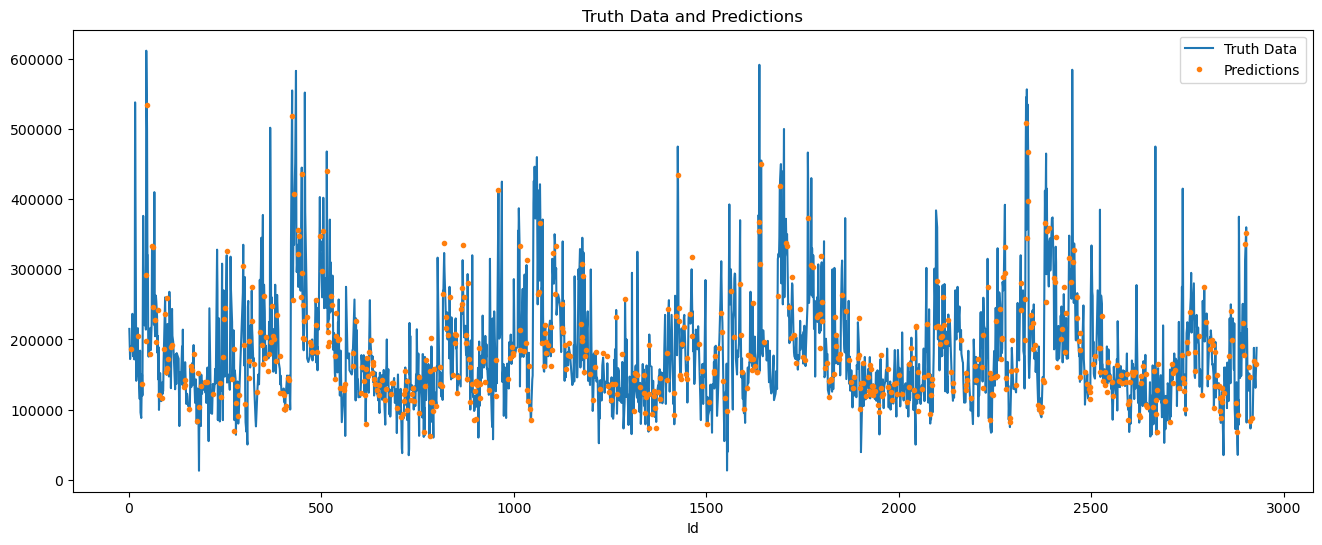

In [171]:
# Evaluating performance, truth data vs predictions
ax = check.SalePrice.plot(figsize=(16,6))
check.preds.plot(ax=ax, style='.', )
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Truth Data and Predictions')
plt.show()

### Ensembling

In [172]:
X_train = zx_train.copy()
X_test = zx_test.copy()

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

In [173]:
X_train.head()

,total_sq_ft,Gr Liv Area,Kitchen AbvGr,Overall Qual,Overall Cond,Lot Area,age,neigh_rank,Fireplaces,Garage Cars,Paved Drive,Kitchen Qual,Garage Qual,Bsmt Qual,1st Flr SF,Heating QC,Exter Qual,Functional,Bsmt Exposure,BsmtFin SF 1,Foundation,Bedroom AbvGr,MS SubClass,total_bathrooms,Mas Vnr Type,Exterior 1st,Screen Porch,Garage Finish,Bsmt Full Bath,Exterior 2nd,TotRms AbvGrd,is_new,Wood Deck SF,Misc Val,Sale Type,Roof Style,Pool Area,Mas Vnr Area,BsmtFin SF 2,Garage Type,Mo Sold,Garage Area,Bsmt Unf SF,Enclosed Porch,Bldg Type,was_remodeled,Neighborhood,Fireplace Qu,Lot Config,Total Bsmt SF,2nd Flr SF,MS Zoning,Electrical,House Style,Year Remod/Add,Condition 2,Heating,has_garage,Bsmt Cond,Open Porch SF,Year Built,Garage Yr Blt,has_basement,Lot Shape,Garage Cond,Half Bath,Full Bath,Central Air,Exter Cond,Low Qual Fin SF,Lot Frontage,BsmtFin Type 1,Condition 1,Street,Roof Matl,3Ssn Porch,Bsmt Half Bath,Land Slope,Land Contour,Yr Sold,Utilities,BsmtFin Type 2
0,0.274790,0.317131,1,5.0,4.0,2.759215,3.931826,1,2,2.0,1,3.0,3.0,3.0,0.926645,2.0,3.0,7,4.0,6.461468,1,3,3.044522,2,4,3,0.000000,3.0,1,10,11,0,5.351858,0.000000,9,3,0.0,4.727388,0.0,1,7,0.162212,6.091310,0.0,0,0,15,4.0,0,0.176036,0.00000,5,4,2,10,2,1,1,4.0,0.190240,7.581210,7.581210,1,0,3.0,0,1,1,3.0,0.0,4.955827,4.0,2,1,1,0.0,0,0,3,4,0,1.0
1,0.025687,-0.187010,1,5.0,5.0,0.939928,3.970292,1,0,1.0,2,4.0,3.0,3.0,0.445562,3.0,3.0,7,1.0,6.828712,1,3,3.044522,1,1,14,0.000000,1.0,0,15,10,0,5.976351,9.433564,9,3,0.0,4.691348,0.0,1,8,-0.732714,6.008813,0.0,0,0,15,3.0,0,0.595822,0.00000,5,4,2,8,2,1,1,3.0,0.065385,7.580189,7.580189,1,0,3.0,1,1,1,3.0,0.0,4.406719,5.0,2,1,1,0.0,0,0,3,4,0,1.0
2,0.051709,-0.273096,1,7.0,4.0,-1.440343,2.944439,3,0,2.0,2,4.0,3.0,4.0,0.363413,5.0,4.0,7,1.0,5.575949,2,2,4.795791,2,3,6,4.976734,2.0,0,6,9,1,0.000000,0.000000,9,1,0.0,0.000000,0.0,1,0,0.089774,6.925595,0.0,4,0,25,3.0,4,0.519804,0.00000,5,4,2,42,2,1,1,3.0,0.254919,7.597396,7.597396,1,0,3.0,0,2,1,3.0,0.0,3.784190,5.0,2,1,1,0.0,0,0,1,4,0,1.0
3,0.547524,0.261091,1,7.0,4.0,-1.272380,2.772589,3,1,2.0,2,4.0,3.0,4.0,0.873168,5.0,4.0,7,1.0,7.074117,2,2,4.795791,4,3,5,0.000000,2.0,1,5,9,1,5.472271,0.000000,9,1,0.0,0.000000,0.0,1,5,0.402371,6.030685,0.0,4,1,25,3.0,4,0.965039,0.00000,5,4,2,46,2,1,1,3.0,0.398396,7.598900,7.598900,1,0,3.0,0,2,1,3.0,0.0,3.688879,6.0,2,1,1,0.0,0,0,3,4,0,1.0
4,0.386505,0.513329,1,6.0,4.0,-0.521309,2.484907,1,1,2.0,2,4.0,3.0,3.0,-0.115970,4.0,3.0,7,1.0,0.000000,2,3,4.110874,3,3,13,0.000000,3.0,0,14,11,1,4.948760,0.000000,9,1,0.0,0.000000,0.0,1,8,-0.140343,6.902743,0.0,0,0,8,3.0,4,0.008157,6.65544,5,4,5,49,2,1,1,3.0,0.182671,7.600902,7.600902,1,3,3.0,1,2,1,3.0,0.0,4.110874,1.0,2,1,1,0.0,0,0,3,4,0,1.0


In [174]:
base_models = [
    ('Linear Reg', lr_model),
    ('NuSVR', nu1),
    ('Random Forest Reg', rfr),
    ('Lasso', model_lasso),
    ('Ridge', rr),
    ('ElasticNet', model_enet),
    ('HGB Reg', hgb),
    ('LightGBM', lgb2),
    ('CatBoost Reg', cbr1),
    ('XGBoost', xgb2),
]   

In [178]:
stacked = StackingRegressor(n_jobs=-1,
                            passthrough=False,
                            estimators = base_models,
                            final_estimator = LinearRegression(n_jobs=-1),
                            cv = 3)

In [179]:
for name, model in base_models:
    start_time = time.time()

    # model.fit(X_train, y_train)  (commented out since models have already been fit above)
    y_pred = model.predict(X_test)
    
    end_time = time.time()

    
    r2 = model.score(X_test, y_test)
    rmse3 = mean_squared_error(y_test, y_pred, squared = False)
    
    print("-------{}-------".format(name))
    print("Coefficient of determination (R^2): {}".format(r2))
    print("Root Mean Squared Error: {}".format(rmse3))
    print("Computation Time: {}".format(end_time - start_time))
    print("----------------------------------\n")

-------Linear Reg-------
Coefficient of determination (R^2): 0.9273244179772572
Root Mean Squared Error: 0.10472902451121911
Computation Time: 0.0010006427764892578
----------------------------------

-------NuSVR-------
Coefficient of determination (R^2): 0.9271054819929869
Root Mean Squared Error: 0.1048866545497928
Computation Time: 0.03399944305419922
----------------------------------

-------Random Forest Reg-------
Coefficient of determination (R^2): 0.9021465226397501
Root Mean Squared Error: 0.1215236851595092
Computation Time: 0.03499960899353027
----------------------------------

-------Lasso-------
Coefficient of determination (R^2): 0.9300056034672933
Root Mean Squared Error: 0.10277901136624738
Computation Time: 0.0009996891021728516
----------------------------------

-------Ridge-------
Coefficient of determination (R^2): 0.9273425081772839
Root Mean Squared Error: 0.10471598927392455
Computation Time: 0.0009999275207519531
----------------------------------

-------El

In [180]:
start_time = time.time()

stacked.fit(X_train, y_train)    
stacked_prediction = stacked.predict(X_test)

end_time = time.time()

stacked_r2 = stacked.score(X_test, y_test)
stacked_rmse = mean_squared_error(y_test, stacked_prediction, squared = False)

print("-------Stacked Ensemble-------")
print("Coefficient of determination (R^2): {}".format(stacked_r2))
print("Root Mean Squared Error: {}".format(stacked_rmse))
print("Computation Time: {}".format(end_time - start_time))
print("----------------------------------")

-------Stacked Ensemble-------
Coefficient of determination (R^2): 0.9406927116535724
Root Mean Squared Error: 0.09460777589770361
Computation Time: 187.71400046348572
----------------------------------


### Output Station

In [181]:
# Test data sorting and index alignment
W_final.sort_index(inplace=True)
W_final.reset_index(inplace=True)

In [182]:
y_output = np.exp(stacked.predict(W_final[X_train.columns])) # predict and remove log

In [183]:
output=pd.DataFrame()
output['Id'] = test2.index
output['SalePrice'] = y_output
output.shape

(878, 2)

In [184]:
output.head()

,Id,SalePrice
0,2,123690.633250
1,4,249223.886277
2,6,192934.666024
3,7,201488.285121
4,17,214716.895258


In [185]:
# don't include index for submission
output.to_csv('./privera_housing_v3.csv', index=False)

In [186]:
# Check to ensure file was successfully created
check = pd.read_csv('./privera_housing_v3.csv')
check.head(7)

,Id,SalePrice
0,2,123690.633250
1,4,249223.886277
2,6,192934.666024
3,7,201488.285121
4,17,214716.895258
5,18,328826.509254
6,22,183732.647774


In [187]:
check.shape

(878, 2)

In [ ]:
# 19401 Kaggle Priv